In [2]:
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('merged_dataset.csv')
df.drop(columns=['id'], inplace=True)

In [4]:
df.head()

,data_hora,ups_work_mode,ups_va_in,ups_vb_in,ups_vc_in,ups_hz_in,ups_va_out,ups_vb_out,ups_vc_out,ups_hz_out,...,pdu5_kwh,pdu6_i,pdu6_fp,pdu6_kwh,pdu7_i,pdu7_fp,pdu7_kwh,pdu8_i,pdu8_fp,pdu8_kwh
0,2024-10-31 20:31:19,4,233.0,233.1,233.6,60.0,219.0,219.2,220.1,59.8,...,3646.7,6.33,0.89,3734.2,5.68,0.96,2544.8,4.52,0.95,2242.8
1,2024-10-31 20:31:29,4,233.1,232.9,233.3,59.9,219.2,219.2,219.9,60.0,...,3646.7,6.25,0.89,3734.2,5.63,0.95,2544.8,4.43,0.95,2242.8
2,2024-10-31 20:31:39,4,232.8,233.0,233.4,59.9,219.4,219.2,220.1,59.8,...,3646.7,6.35,0.89,3734.2,5.63,0.95,2544.8,4.45,0.95,2242.8
3,2024-10-31 20:31:49,4,232.9,233.1,233.5,59.8,219.4,219.4,220.1,59.9,...,3646.7,6.30,0.88,3734.2,5.83,0.94,2544.8,4.43,0.95,2242.8
4,2024-10-31 20:32:00,4,232.9,233.1,233.5,59.9,219.0,219.2,219.9,59.7,...,3646.7,6.30,0.88,3734.2,5.63,0.96,2544.8,4.44,0.94,2242.8


In [5]:
df_ups = df[[col for col in df.columns if col.startswith('ups')] + ['data_hora']].copy()
df_ups.columns

Index(['ups_work_mode', 'ups_va_in', 'ups_vb_in', 'ups_vc_in', 'ups_hz_in',
       'ups_va_out', 'ups_vb_out', 'ups_vc_out', 'ups_hz_out', 'ups_ia_out',
       'ups_ib_out', 'ups_ic_out', 'ups_pa', 'ups_pb', 'ups_pc', 'ups_sa',
       'ups_sb', 'ups_sc', 'ups_load_a_out', 'ups_load_b_out',
       'ups_load_c_out', 'ups_load', 'ups_load_sa', 'ups_load_sb',
       'ups_load_sc', 'ups_load_s', 'ups_p_cell_v', 'ups_n_cell_v',
       'ups_bat_i_charge', 'ups_bat_i_discharge', 'ups_bat_ah',
       'ups_byp_status', 'ups_byp_va', 'ups_byp_vb', 'ups_byp_vc',
       'ups_byp_ia', 'ups_byp_ib', 'ups_byp_ic', 'ups_byp_hz', 'data_hora'],
      dtype='object')

## UPS_V

In [6]:
def window_dataframe(df, window_size=12):
    """
    Returns a DataFrame with columns grouped by variable, then window index.
    E.g., va-1-1, va-1-2, ..., vb-1-1, vb-1-2, ...
    """
    n_rows = df.shape[0]
    n_windows = n_rows // window_size
    df_trunc = df.iloc[:n_windows * window_size]
    data = df_trunc.values.reshape(n_windows, window_size, df.shape[1])
    # Build new column names: for each variable, all window steps
    new_columns = []
    for col in df.columns:
        for i in range(window_size):
            base = col.replace('met_', '').replace('_1', '')
            new_columns.append(f"{base}-1-{i+1}")
    # Transpose axes to get all time steps for each variable together
    data_2d = data.transpose(0,2,1).reshape(n_windows, -1)
    return pd.DataFrame(data_2d, columns=new_columns)

In [7]:
df_ups_v = df_ups[['ups_work_mode', 'ups_va_in', 'ups_vb_in', 'ups_vc_in','ups_va_out', 'ups_vb_out', 'ups_vc_out']].copy()

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Supervisor anomaly intervals
supervisor_anomalies = [
   (pd.Timestamp('2025-01-04 06:40'), pd.Timestamp('2025-01-04 06:42')),
    (pd.Timestamp('2025-01-04 06:42'), pd.Timestamp('2025-01-04 06:44')),
    (pd.Timestamp('2025-01-04 10:33'), pd.Timestamp('2025-01-04 10:35')),
    (pd.Timestamp('2025-02-10 13:46'), pd.Timestamp('2025-02-10 13:48')),
    (pd.Timestamp('2025-02-14 19:20'), pd.Timestamp('2025-02-14 19:22'))
]

# Evaluation helpers
def is_true_positive(ts, intervals):
    return any(start <= ts <= end for start, end in intervals)

def compare_anomalies(detected_indices, intervals):
    true_positives = [ts for ts in detected_indices if is_true_positive(ts, intervals)]
    false_positives = [ts for ts in detected_indices if not is_true_positive(ts, intervals)]
    false_negatives = [interval for interval in intervals if not any(is_true_positive(ts, [interval]) for ts in detected_indices)]
    return true_positives, false_positives, false_negatives

def window_dataframe(df, window_size=12):
    """
    Transform UPS DataFrame into windowed format.
    Returns a DataFrame where each row is a time window of fixed size,
    and columns are named by variable and time index.
    """
    n_rows = df.shape[0]
    n_windows = n_rows // window_size
    df_trunc = df.iloc[:n_windows * window_size]
    data = df_trunc.values.reshape(n_windows, window_size, df.shape[1])

    # Build new column names: for each variable, all window steps
    new_columns = []
    for col in df.columns:
        for i in range(window_size):
            new_columns.append(f"{col}-{i+1}")

    # Transpose axes to get all time steps for each variable together
    data_2d = data.transpose(0, 2, 1).reshape(n_windows, -1)
    return pd.DataFrame(data_2d, columns=new_columns)

def build_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(64, input_shape=(input_dim,), kernel_regularizer=regularizers.l2(1e-4)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.1))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-4)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(16, kernel_regularizer=regularizers.l2(1e-4)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(input_dim, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm_autoencoder(seq_len, n_features):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(seq_len, n_features)),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        RepeatVector(seq_len),
        LSTM(32, return_sequences=True),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        LeakyReLU(alpha=0.1),
        TimeDistributed(Dense(n_features))
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return model

# Multi-window-size analysis
window_sizes = [12, 16, 25] # 2, 3 and 5 minutes window size
results = []
phases = ['ups_work_mode', 'ups_va_in', 'ups_vb_in', 'ups_vc_in','ups_va_out', 'ups_vb_out', 'ups_vc_out']

for window_size in window_sizes:
    df_ups_v = df_ups[['ups_work_mode', 'ups_va_in', 'ups_vb_in', 'ups_vc_in','ups_va_out', 'ups_vb_out', 'ups_vc_out']].copy()
    df_ups_v_win = window_dataframe(df_ups_v, window_size=window_size)
    df_ups_v_win_plot = df_ups_v_win.copy()

    for phase in phases:
        cols = [f"{phase}-{i+1}" for i in range(window_size)]
        df_ups_v_win_plot[f"{phase}_mean"] = df_ups_v_win_plot[cols].mean(axis=1)

    timestamps = df_ups['data_hora'].sort_values().values
    n_windows = len(df_ups_v_win_plot)
    window_timestamps = [timestamps[(i+1)*window_size - 1] for i in range(n_windows)]
    df_ups_v_win_plot['window_time'] = pd.to_datetime(window_timestamps)
    df_ups_v_win_plot = df_ups_v_win_plot.set_index('window_time')

    test_start = pd.to_datetime('2024-12-29')
    test_end = pd.to_datetime('2025-02-23')
    test_mask = (df_ups_v_win_plot.index >= test_start) & (df_ups_v_win_plot.index <= test_end)
    df_test_win = df_ups_v_win_plot[test_mask].copy()
    df_train_win = df_ups_v_win_plot[~test_mask].copy()

    X_train_volt = df_train_win.drop(columns=[c for c in df_train_win.columns if c.endswith('_mean')])
    X_test_volt = df_test_win.drop(columns=[c for c in df_test_win.columns if c.endswith('_mean')])

    # === Autoencoder ===
    scaler_ae = StandardScaler()
    X_train_ae_volt = scaler_ae.fit_transform(X_train_volt)
    X_test_ae_volt = scaler_ae.transform(X_test_volt)

    model_ae = build_autoencoder(X_train_ae_volt.shape[1])
    model_ae.fit(X_train_ae_volt, X_train_ae_volt, epochs=30, batch_size=32, validation_split=0.1,
                 callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)

    recon_ae_volt = model_ae.predict(X_test_ae_volt)
    recon_err_ae_volt = np.mean((X_test_ae_volt - recon_ae_volt)**2, axis=1)
    thresh_ae_volt = np.percentile(recon_err_ae_volt, 99.8)
    labels_ae_volt = (recon_err_ae_volt > thresh_ae_volt).astype(int)

    # === LSTM ===
    scaler_lstm = MinMaxScaler()
    X_train_lstm_volt = scaler_lstm.fit_transform(X_train_volt)
    X_test_lstm_volt = scaler_lstm.transform(X_test_volt)
    X_train_seq_volt = X_train_lstm_volt.reshape(-1, window_size, 7)
    X_test_seq_volt = X_test_lstm_volt.reshape(-1, window_size, 7)

    model_lstm = build_lstm_autoencoder(window_size, 7)
    model_lstm.fit(X_train_seq_volt, X_train_seq_volt, epochs=30, batch_size=32, validation_split=0.1,
                   callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)

    recon_lstm_volt = model_lstm.predict(X_test_seq_volt)
    recon_err_lstm_volt = np.mean(np.square(X_test_seq_volt - recon_lstm_volt), axis=(1, 2))
    thresh_lstm_volt = np.percentile(recon_err_lstm_volt, 99.8)
    labels_lstm_volt = (recon_err_lstm_volt > thresh_lstm_volt).astype(int)

    # Compare to supervisor labels
    detected_ae = df_test_win.index[labels_ae_volt == 1]
    detected_lstm = df_test_win.index[labels_lstm_volt == 1]
    tp_ae, fp_ae, fn_ae = compare_anomalies(detected_ae, supervisor_anomalies)
    tp_lstm, fp_lstm, fn_lstm = compare_anomalies(detected_lstm, supervisor_anomalies)

    results.append({
        "Model": "Autoencoder", "Window Size": window_size, "Total Detected": len(detected_ae),
        "True Positives": len(tp_ae), "False Positives": len(fp_ae), "False Negatives": len(fn_ae)
    })
    results.append({
        "Model": "LSTM", "Window Size": window_size, "Total Detected": len(detected_lstm),
        "True Positives": len(tp_lstm), "False Positives": len(fp_lstm), "False Negatives": len(fn_lstm)
    })


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


692/692 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


519/519 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [9]:
summary_v = pd.DataFrame(results)
summary_v

,Model,Window Size,Total Detected,True Positives,False Positives,False Negatives
0,Autoencoder,12,45,3,42,2
1,LSTM,12,45,3,42,2
2,Autoencoder,16,34,2,32,3
3,LSTM,16,34,2,32,3
4,Autoencoder,25,22,2,20,3
5,LSTM,25,22,2,20,3


C:\Users\ghofr\AppData\Local\Temp\ipykernel_17396\2549063992.py:62: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\ghofr\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


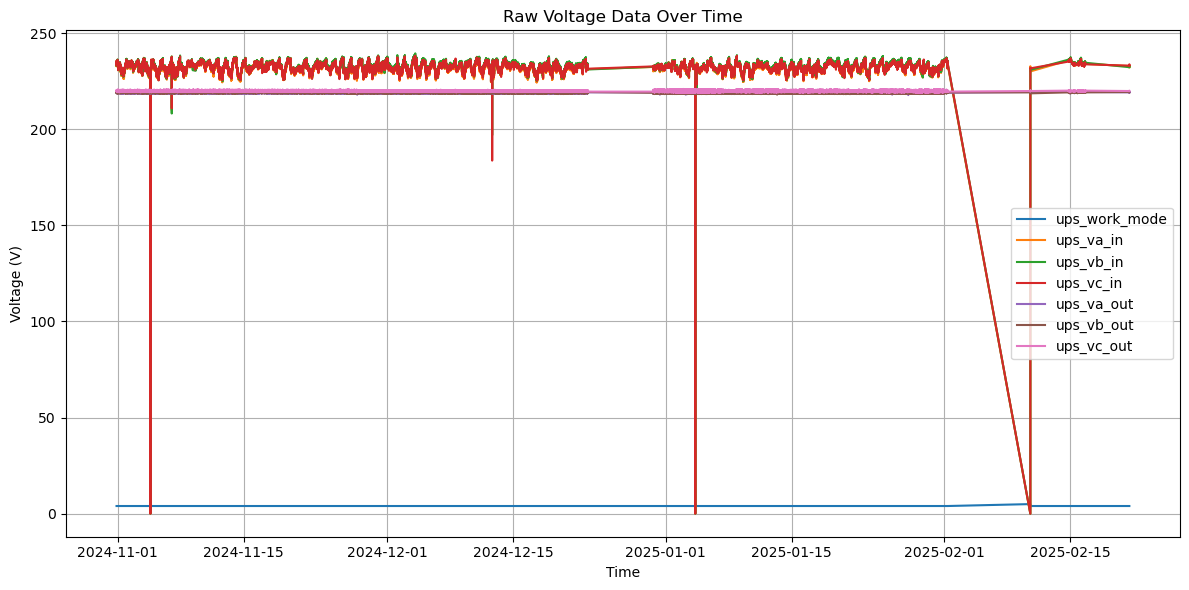

Epoch 1/50


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5845 - val_loss: 0.3842
Epoch 2/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4402 - val_loss: 0.3680
Epoch 3/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4400 - val_loss: 0.3572
Epoch 4/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5178 - val_loss: 0.3512
Epoch 5/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5283 - val_loss: 0.3443
Epoch 6/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4208 - val_loss: 0.3392
Epoch 7/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3772 - val_loss: 0.3423
Epoch 8/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4074 - val_loss: 0.3361
Epoch 9/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3974 - val_loss: 0.3339
Epoch 10/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3996 - val_loss: 0.3310
Epoch 11/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3828 - val_loss: 0.3304
Epoch 12/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.

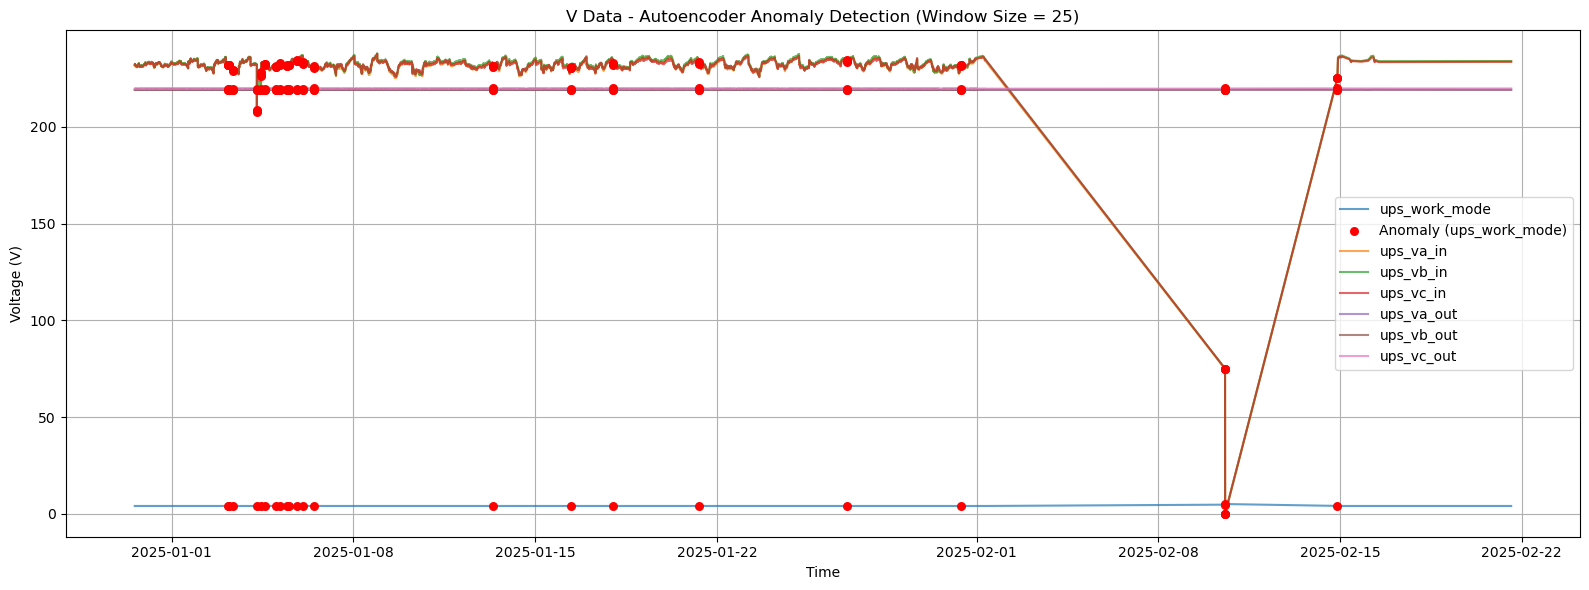

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
# Supervisor anomaly intervals
supervisor_anomalies = [
   (pd.Timestamp('2025-01-04 06:40'), pd.Timestamp('2025-01-04 06:42')),
    (pd.Timestamp('2025-01-04 06:42'), pd.Timestamp('2025-01-04 06:44')),
    (pd.Timestamp('2025-01-04 10:33'), pd.Timestamp('2025-01-04 10:35')),
    (pd.Timestamp('2025-02-10 13:46'), pd.Timestamp('2025-02-10 13:48')),
    (pd.Timestamp('2025-02-14 19:20'), pd.Timestamp('2025-02-14 19:22'))
]

# Evaluation helpers
def is_true_positive(ts, intervals):
    return any(start <= ts <= end for start, end in intervals)

def compare_anomalies(detected_indices, intervals):
    true_positives = [ts for ts in detected_indices if is_true_positive(ts, intervals)]
    false_positives = [ts for ts in detected_indices if not is_true_positive(ts, intervals)]
    false_negatives = [interval for interval in intervals if not any(is_true_positive(ts, [interval]) for ts in detected_indices)]
    return true_positives, false_positives, false_negatives

def window_dataframe_v(df, window_size=12):
    """
    Transform UPS DataFrame into windowed format.
    Returns a DataFrame where each row is a time window of fixed size,
    and columns are named by variable and time index.
    """
    n_rows = df.shape[0]
    n_windows = n_rows // window_size
    df_trunc = df.iloc[:n_windows * window_size]
    data = df_trunc.values.reshape(n_windows, window_size, df.shape[1])

    # Build new column names: for each variable, all window steps
    new_columns = []
    for col in df.columns:
        for i in range(window_size):
            new_columns.append(f"{col}-{i+1}")
    # Transpose axes to get all time steps for each variable together
    data_2d = data.transpose(0, 2, 1).reshape(n_windows, -1)
    return pd.DataFrame(data_2d, columns=new_columns)


# Plot raw voltage means
v_phases = ['ups_work_mode', 'ups_va_in', 'ups_vb_in', 'ups_vc_in','ups_va_out', 'ups_vb_out', 'ups_vc_out']
df_ups['data_hora'] = pd.to_datetime(df_ups['data_hora'])
df_ups = df_ups.sort_values('data_hora')
plt.figure(figsize=(12, 6))
for phase in v_phases:
    plt.plot(df_ups['data_hora'], df_ups[phase], label=phase)
plt.title("Raw Voltage Data Over Time")
plt.xlabel("Time")
plt.ylabel("Voltage (V)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Best model and window selection (from previous summary)
best_window_volt = 25
best_model_volt = "Autoencoder"

# Prepare data
df_v_ups = df_ups[['ups_work_mode', 'ups_va_in', 'ups_vb_in', 'ups_vc_in','ups_va_out', 'ups_vb_out', 'ups_vc_out']].copy()
df_v_ups_win = window_dataframe_v(df_v_ups, window_size=best_window_volt)
df_v_ups_win_plot = df_v_ups_win.copy()
v_phases_clean = ['ups_work_mode', 'ups_va_in', 'ups_vb_in', 'ups_vc_in','ups_va_out', 'ups_vb_out', 'ups_vc_out']
for phase in v_phases_clean:
    cols = [f"{phase}-{i+1}" for i in range(best_window_volt)]
    missing_cols = [col for col in cols if col not in df_v_ups_win_plot.columns]
    if missing_cols:
        print(f"Colonnes manquantes pour {phase} : {missing_cols}")
        continue
    df_v_ups_win_plot[f"{phase}_mean"] = df_v_ups_win_plot[cols].mean(axis=1)
timestamps_v = df_ups['data_hora'].sort_values().values
n_windows_v = len(df_v_ups_win_plot)
window_timestamps_v = [timestamps_v[(i+1)*best_window_volt - 1] for i in range(n_windows_v)]
df_v_ups_win_plot['window_time'] = pd.to_datetime(window_timestamps_v)
df_v_ups_win_plot = df_v_ups_win_plot.set_index('window_time')

# Train-test split
test_start_v = pd.to_datetime('2024-12-29')
test_end_v = pd.to_datetime('2025-02-23')
test_mask_v = (df_v_ups_win_plot.index >= test_start_v) & (df_v_ups_win_plot.index <= test_end_v)
df_test_v = df_v_ups_win_plot[test_mask_v].copy()
df_train_v = df_v_ups_win_plot[~test_mask_v].copy()

X_train_v = df_train_v.drop(columns=[c for c in df_train_v.columns if c.endswith('_mean')])
X_test_v = df_test_v.drop(columns=[c for c in df_test_v.columns if c.endswith('_mean')])

# === Final Autoencoder ===
def build_final_autoencoder_volt(input_dim):
    model = Sequential()
    model.add(Dense(64, input_shape=(input_dim,), kernel_regularizer=regularizers.l2(1e-4)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.1))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-4)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(16, kernel_regularizer=regularizers.l2(1e-4)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(input_dim, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

# === Final LSTM ===
def build_final_lstm_volt(seq_len, n_features):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(seq_len, n_features)),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        RepeatVector(seq_len),
        LSTM(32, return_sequences=True),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        LeakyReLU(alpha=0.1),
        TimeDistributed(Dense(n_features))
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return model

if best_model_volt == "Autoencoder":
    scaler_volt = StandardScaler()
    X_train_volt_scaled = scaler_volt.fit_transform(X_train_v)
    X_test_volt_scaled = scaler_volt.transform(X_test_v)
    model_volt = build_final_autoencoder_volt(X_train_volt_scaled.shape[1])
    model_volt.fit(X_train_volt_scaled, X_train_volt_scaled, epochs=50, batch_size=32, validation_split=0.1,
              callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=1)
    recon_volt = model_volt.predict(X_test_volt_scaled)
    errors_volt = np.mean(np.square(X_test_volt_scaled - recon_volt), axis=1)
else:
    scaler_volt = MinMaxScaler()
    X_train_volt_scaled = scaler_volt.fit_transform(X_train_v)
    X_test_volt_scaled = scaler_volt.transform(X_test_v)
    n_features_volt = 7
    sequence_length_volt = best_window_volt
    X_train_seq_volt = X_train_volt_scaled.reshape(-1, sequence_length_volt, n_features_volt)
    X_test_seq_volt = X_test_volt_scaled.reshape(-1, sequence_length_volt, n_features_volt)
    model_volt = build_final_lstm_volt(sequence_length_volt, n_features_volt)
    model_volt.fit(X_train_seq_volt, X_train_seq_volt, epochs=50, batch_size=32, validation_split=0.1,
              callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=1)
    recon_seq_volt = model_volt.predict(X_test_seq_volt)
    errors_volt = np.mean(np.square(X_test_seq_volt - recon_seq_volt), axis=(1, 2))

threshold_volt = np.percentile(errors_volt, 99.8)
anomalies_volt = errors_volt > threshold_volt
df_test_v['anomaly_score'] = errors_volt
df_test_v['predicted_label'] = anomalies_volt.astype(int)

# Plot final anomaly results
phase_labels_v = ['ups_work_mode', 'ups_va_in', 'ups_vb_in', 'ups_vc_in','ups_va_out', 'ups_vb_out', 'ups_vc_out']
plt.figure(figsize=(16, 6))
for phase, label in zip(v_phases_clean, phase_labels_v):
    plt.plot(df_test_v.index, df_test_v[f"{phase}_mean"], label=label, alpha=0.7)
    plt.scatter(
        df_test_v.index[df_test_v['predicted_label'] == 1],
        df_test_v.loc[df_test_v['predicted_label'] == 1, f"{phase}_mean"],
        color='red', s=30, zorder=10, label=f"Anomaly ({label})" if phase == v_phases_clean[0] else ""
    )
plt.title(f"V Data - {best_model_volt} Anomaly Detection (Window Size = {best_window_volt})")
plt.xlabel("Time")
plt.ylabel("Voltage (V)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# Compare to supervisor labels for voltage data
detected_v_anomalies = df_test_v.index[df_test_v['predicted_label'] == 1]
tp_volt, fp_volt, fn_volt = compare_anomalies(detected_v_anomalies, supervisor_anomalies)

# Create and display summary
v_summary = pd.DataFrame({
    "Model": [best_model_volt],
    "Window Size": [best_window_volt],
    "Total Detected": [len(detected_v_anomalies)],
    "True Positives": [len(tp_volt)],
    "False Positives": [len(fp_volt)],
    "False Negatives": [len(fn_volt)],
})

print("\nVoltage Anomaly Detection Performance Summary:")
v_summary


Voltage Anomaly Detection Performance Summary:


,Model,Window Size,Total Detected,True Positives,False Positives,False Negatives
0,Autoencoder,25,22,2,20,3


In [12]:
# Print detailed results
print("\nDetailed Results:")
print(f"Total anomalies detected: {len(detected_v_anomalies)}")
print(f"True positives: {len(tp_volt)}")
print(f"False positives: {len(fp_volt)}")
print(f"False negatives: {len(fn_volt)}")

# Print the actual timestamps of anomalies
print("\nDetected Voltage Anomaly Timestamps:")
print(detected_v_anomalies)

# Print supervisor's anomaly intervals that were missed (false negatives)
if len(fn_volt) > 0:
    print("\nMissed Voltage Anomaly Intervals (False Negatives):")
    for interval in fn_volt:
        print(f"From {interval[0]} to {interval[1]}")
else:
    print("\nNo missed voltage anomalies (all supervisor intervals detected)")


Detailed Results:
Total anomalies detected: 22
True positives: 2
False positives: 20
False negatives: 3

Detected Voltage Anomaly Timestamps:
DatetimeIndex(['2025-01-03 03:50:35', '2025-01-03 05:03:33',
               '2025-01-03 08:55:56', '2025-01-04 06:42:56',
               '2025-01-04 10:35:13', '2025-01-04 14:05:52',
               '2025-01-05 00:20:57', '2025-01-05 04:04:24',
               '2025-01-05 10:52:39', '2025-01-05 12:31:43',
               '2025-01-05 19:34:12', '2025-01-06 01:27:01',
               '2025-01-06 11:37:45', '2025-01-13 09:10:14',
               '2025-01-16 08:45:00', '2025-01-18 00:01:55',
               '2025-01-21 07:32:00', '2025-01-26 23:58:00',
               '2025-01-31 09:55:26', '2025-02-10 13:41:55',
               '2025-02-10 13:46:13', '2025-02-14 21:35:34'],
              dtype='datetime64[ns]', name='window_time', freq=None)

Missed Voltage Anomaly Intervals (False Negatives):
From 2025-01-04 06:40:00 to 2025-01-04 06:42:00
From 2025-01-04

### Saving the model 

In [13]:
from joblib import dump
from tensorflow.keras.models import save_model
import os

# === Step 1: Définir un dossier local (ex: projet dans ton home dir ou un dossier spécifique) ===
base_dir = "anomaly_detection_project"  # ou un chemin complet, ex: "C:/Users/TonNom/Documents/anomaly_detection_project"

# Sous-dossiers par type de mesure
subset_dirs = {
    "UPS_V": os.path.join(base_dir, "UPS_V"),
    "UPS_P": os.path.join(base_dir, "UPS_P"),
    "UPS_I": os.path.join(base_dir, "UPS_I"),
    "UPS_bat": os.path.join(base_dir, "UPS_bat")
}

# Créer les dossiers si besoin
for dir_path in subset_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# === Step 2: Sauvegarder le modèle et le scaler ===
save_model(model_volt, os.path.join(subset_dirs["UPS_V"], "autoencoder_model.keras"))
dump(scaler_volt, os.path.join(subset_dirs["UPS_V"], "scaler.pkl"))

# === Step 3: Sauvegarder les résultats (si `voltage_summary` existe) ===
v_summary.to_csv(os.path.join(subset_dirs["UPS_V"], "summary.csv"), index=False)


In [14]:
import os
from tensorflow.keras.models import load_model
from joblib import load

# === Base path local ===
base_dir = "anomaly_detection_project"  # ou un chemin absolu comme "C:/Users/TonNom/Documents/anomaly_detection_project"

# === Nom du sous-dossier (doit correspondre à la sauvegarde précédente) ===
subset = "UPS_V"  # <- par exemple, pour voltage

# === Construction des chemins ===
model_path = os.path.join(base_dir, subset, "autoencoder_model.keras")
scaler_path = os.path.join(base_dir, subset, "scaler.pkl")

# === Chargement ===
model = load_model(model_path)
scaler = load(scaler_path)

print("✅ Model and scaler loaded successfully!")

✅ Model and scaler loaded successfully!


## UPS_I

In [15]:
# Extract current data from original dataset with timestamps
df_ups_i_original = df_ups[['data_hora', 'ups_ia_out','ups_ib_out','ups_ic_out']].copy()

# Ensure the timestamp is in datetime format
df_ups_i_original['data_hora'] = pd.to_datetime(df_ups_i_original['data_hora'])

In [16]:
df_ups_i_original.head()

,data_hora,ups_ia_out,ups_ib_out,ups_ic_out
0,2024-10-31 20:31:19,16.0,8.2,9.1
1,2024-10-31 20:31:29,16.0,8.5,9.1
2,2024-10-31 20:31:39,16.2,8.5,9.1
3,2024-10-31 20:31:49,16.2,8.5,9.3
4,2024-10-31 20:32:00,16.0,8.2,9.3


In [17]:
df_ups_i_original.shape

(704248, 4)

In [18]:
import pandas as pd
import os

file_path_ups_i = 'ups_i.csv'  

# Lecture du fichier CSV
try:
    df_ups_i = pd.read_csv(file_path_ups_i)
    print("File loaded successfully!")

    # Affichage des premières lignes
    print("\nFirst 5 rows of the dataframe:")
    print(df_ups_i.head())

except FileNotFoundError:
    print(f"❌ File not found at path: {file_path_ups_i}")
except Exception as e:
    print(f"⚠️ An error occurred: {str(e)}")

File loaded successfully!

First 5 rows of the dataframe:
                        time  ups_ia_output  ups_ib_output  ups_ic_output
0  2025-02-01 00:00:00+00:00          12.55            9.3          10.20
1  2025-02-01 00:00:20+00:00          12.10            9.1           9.75
2  2025-02-01 00:00:40+00:00          12.40            8.8          10.00
3  2025-02-01 00:01:00+00:00          12.25            9.1           9.90
4  2025-02-01 00:01:20+00:00          12.10            9.2           9.60


In [19]:
# Rename Columns and Convert timestamp 
df_ups_i = df_ups_i.rename(columns={
    'ups_ia_output': 'ups_ia_out',
    'ups_ib_output': 'ups_ib_out',
    'ups_ic_output': 'ups_ic_out',
    'time':'data_hora' 
})
df_ups_i['data_hora']= pd.to_datetime(df_ups_i['data_hora']).dt.tz_localize(None)

df_ups_i.head()

,data_hora,ups_ia_out,ups_ib_out,ups_ic_out
0,2025-02-01 00:00:00,12.55,9.3,10.20
1,2025-02-01 00:00:20,12.10,9.1,9.75
2,2025-02-01 00:00:40,12.40,8.8,10.00
3,2025-02-01 00:01:00,12.25,9.1,9.90
4,2025-02-01 00:01:20,12.10,9.2,9.60


In [20]:
df_ups_i.shape

(533790, 4)

In [21]:
# Combine both datasets
df_combined_i = pd.concat([df_ups_i_original, df_ups_i])

# Sort by timestamp
df_combined_i = df_combined_i.sort_values('data_hora').reset_index(drop=True)

# Check for duplicates and remove them
df_combined_i = df_combined_i.drop_duplicates(subset='data_hora', keep='first')

In [22]:
df_combined_i.shape

(1237992, 4)

In [23]:
df_combined_i.head()

,data_hora,ups_ia_out,ups_ib_out,ups_ic_out
0,2024-10-31 20:31:19,16.0,8.2,9.1
1,2024-10-31 20:31:29,16.0,8.5,9.1
2,2024-10-31 20:31:39,16.2,8.5,9.1
3,2024-10-31 20:31:49,16.2,8.5,9.3
4,2024-10-31 20:32:00,16.0,8.2,9.3


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# === Supervisor anomaly intervals
supervisor_anomalies_i = [
    (pd.Timestamp('2025-01-06 09:11'), pd.Timestamp('2025-01-06 09:14')),
    (pd.Timestamp('2025-01-09 14:26'), pd.Timestamp('2025-01-09 14:29')),
    (pd.Timestamp('2025-01-29 11:18'), pd.Timestamp('2025-01-29 11:21')),
    (pd.Timestamp('2025-01-29 11:40'), pd.Timestamp('2025-01-29 11:44')),
    (pd.Timestamp('2025-01-29 13:10'), pd.Timestamp('2025-01-29 13:14')),
    (pd.Timestamp('2025-01-29 13:45'), pd.Timestamp('2025-01-29 13:51')),
    (pd.Timestamp('2025-01-22 13:42'), pd.Timestamp('2025-01-22 13:44')),
    (pd.Timestamp('2025-01-22 13:42'), pd.Timestamp('2025-01-22 13:44')),
    (pd.Timestamp('2025-01-28 09:53'), pd.Timestamp('2025-01-28 09:54')),
    (pd.Timestamp('2025-01-28 09:55'), pd.Timestamp('2025-01-28 09:57')),
    (pd.Timestamp('2025-01-28 09:57'), pd.Timestamp('2025-01-28 09:59')),
    (pd.Timestamp('2025-01-28 10:02'), pd.Timestamp('2025-01-28 10:04')),
    (pd.Timestamp('2025-01-28 10:04'), pd.Timestamp('2025-01-28 10:06')),
    (pd.Timestamp('2025-01-28 10:05'), pd.Timestamp('2025-01-28 10:07')),
    (pd.Timestamp('2025-01-28 10:14'), pd.Timestamp('2025-01-28 10:16')),
    (pd.Timestamp('2025-01-07 11:07'), pd.Timestamp('2025-01-07 11:09')),
    (pd.Timestamp('2025-01-07 12:12'), pd.Timestamp('2025-01-07 12:16')),
    (pd.Timestamp('2025-01-08 14:03'), pd.Timestamp('2025-01-08 14:07')),
    (pd.Timestamp('2025-01-08 17:19'), pd.Timestamp('2025-01-08 17:23')),
    (pd.Timestamp('2025-01-10 13:46'), pd.Timestamp('2025-01-10 13:48')),
    (pd.Timestamp('2025-01-10 15:10'), pd.Timestamp('2025-01-10 15:11')),
    (pd.Timestamp('2025-01-13 16:04'), pd.Timestamp('2025-01-13 16:07')),
    (pd.Timestamp('2025-01-13 16:07'), pd.Timestamp('2025-01-13 16:09')),
    (pd.Timestamp('2025-01-15 15:20'), pd.Timestamp('2025-01-15 15:23')),
    (pd.Timestamp('2025-01-16 15:20'), pd.Timestamp('2025-01-16 15:27')),
    (pd.Timestamp('2025-01-22 14:27'), pd.Timestamp('2025-01-22 14:29')),
    (pd.Timestamp('2025-01-29 15:26'), pd.Timestamp('2025-01-29 15:27')),
    (pd.Timestamp('2025-01-24 13:58'), pd.Timestamp('2025-01-24 14:03')),
    (pd.Timestamp('2025-01-29 15:00'), pd.Timestamp('2025-01-29 15:02')),
    (pd.Timestamp('2025-01-29 15:32'), pd.Timestamp('2025-01-29 15:35')),
    (pd.Timestamp('2025-01-29 15:05'), pd.Timestamp('2025-01-29 15:08')),
    (pd.Timestamp('2025-01-29 16:03'), pd.Timestamp('2025-01-29 16:18'))
]    

In [25]:
def window_dataframe(df, window_size):
    """Enhanced windowing function that preserves timestamps"""
    # Get features (excluding timestamp)
    features = df.drop(columns=['data_hora']).values
    n_rows = features.shape[0]
    n_windows = n_rows // window_size

    # Window the features
    windowed_features = features[:n_windows * window_size].reshape(n_windows, window_size, -1)

    # Get the last timestamp of each window
    window_timestamps = df['data_hora'].iloc[(window_size-1)::window_size].values[:n_windows]

    # Create column names
    new_columns = []
    for col in df.columns:
        if col != 'data_hora':
            base = col.replace('met_', '').replace('_1', '')
            new_columns += [f"{base}-1-{i+1}" for i in range(window_size)]

    # Reshape data
    windowed_data = windowed_features.transpose(0, 2, 1).reshape(n_windows, -1)
    windowed_df = pd.DataFrame(windowed_data, columns=new_columns)

    # Add timestamps
    windowed_df['window_time'] = pd.to_datetime(window_timestamps)

    return windowed_df.set_index('window_time')

In [26]:
from typing import List, Tuple
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

# === Enhanced Utility Functions ===

def is_true_positive(ts: pd.Timestamp, intervals: List[Tuple[pd.Timestamp, pd.Timestamp]]) -> bool:
    """Check if a timestamp falls within any anomaly interval."""
    return any(start <= ts <= end for start, end in intervals)

def compare_anomalies_with_metrics(
    detected_indices: List[pd.Timestamp],
    intervals: List[Tuple[pd.Timestamp, pd.Timestamp]],
    all_timestamps: List[pd.Timestamp]
) -> Tuple[float, float, float]:
    """
    Calculate precision, recall, and F1-score for anomaly detection.

    Args:
        detected_indices: List of timestamps where anomalies were detected
        intervals: List of supervisor-labeled anomaly intervals (start, end)
        all_timestamps: All timestamps in the test set

    Returns:
        Tuple of (precision, recall, f1)
    """
    # Create binary vectors for true and predicted anomalies
    y_true = np.array([1 if is_true_positive(ts, intervals) else 0 for ts in all_timestamps])
    y_pred = np.array([1 if ts in detected_indices else 0 for ts in all_timestamps])

    # Calculate metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return precision, recall, f1

def window_dataframe(
    df: pd.DataFrame,
    window_size: int,
    timestamp_col: str = 'data_hora'
) -> pd.DataFrame:
    """
    Convert time series data into windowed format while preserving timestamps.

    Args:
        df: Input DataFrame with time series data
        window_size: Number of time steps per window
        timestamp_col: Name of the timestamp column

    Returns:
        Windowed DataFrame with multi-time-step features
    """
    # Get features (excluding timestamp)
    features = df.drop(columns=[timestamp_col]).values
    n_rows = features.shape[0]
    n_windows = n_rows // window_size

    # Window the features
    windowed_features = features[:n_windows * window_size].reshape(n_windows, window_size, -1)

    # Get the last timestamp of each window
    window_timestamps = df[timestamp_col].iloc[(window_size-1)::window_size].values[:n_windows]

    # Create column names
    new_columns = []
    for col in df.columns:
         if col != timestamp_col:
            new_columns += [f"{col}-t-{i+1}" for i in range(window_size)]


    # Reshape data and create DataFrame
    windowed_data = windowed_features.transpose(0, 2, 1).reshape(n_windows, -1)
    windowed_df = pd.DataFrame(windowed_data, columns=new_columns)

    # Add timestamps as index
    windowed_df['window_time'] = pd.to_datetime(window_timestamps)
    windowed_df = windowed_df.set_index('window_time')

    return windowed_df

def build_autoencoder(
    input_dim: int,
    hidden_dims: List[int] = [64, 32, 16],
    l2_reg: float = 1e-4,
    dropout_rate: float = 0.1,
    leaky_alpha: float = 0.1
) -> Sequential:
    """
    Build a symmetric autoencoder model with configurable architecture.

    Args:
        input_dim: Dimension of input features
        hidden_dims: List of hidden layer dimensions (encoder part)
        l2_reg: L2 regularization factor
        dropout_rate: Dropout rate
        leaky_alpha: Alpha parameter for LeakyReLU

    Returns:
        Compiled autoencoder model
    """
    model = Sequential()

    # Encoder
    for dim in hidden_dims:
        model.add(Dense(dim, kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(LeakyReLU(alpha=leaky_alpha))
        model.add(Dropout(dropout_rate))

    # Decoder (symmetric to encoder)
    for dim in reversed(hidden_dims[:-1]):
        model.add(Dense(dim))
        model.add(LeakyReLU(alpha=leaky_alpha))

    # Final output layer
    model.add(Dense(input_dim, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return model

def build_lstm_autoencoder(
    seq_len: int,
    n_features: int,
    encoder_dims: List[int] = [64, 32],
    decoder_dims: List[int] = [32, 64],
    dropout_rate: float = 0.2,
    leaky_alpha: float = 0.1
) -> Sequential:
    """
    Build an LSTM autoencoder model with configurable architecture.

    Args:
        seq_len: Length of input sequences
        n_features: Number of features per time step
        encoder_dims: List of encoder LSTM units
        decoder_dims: List of decoder LSTM units
        dropout_rate: Dropout rate
        leaky_alpha: Alpha parameter for LeakyReLU

    Returns:
        Compiled LSTM autoencoder model
    """
    model = Sequential()

    # Encoder
    for i, units in enumerate(encoder_dims):
        return_sequences = i < len(encoder_dims) - 1  # Only last encoder layer doesn't return sequences
        model.add(LSTM(units, return_sequences=return_sequences,
                      input_shape=(seq_len, n_features) if i == 0 else None))
        model.add(LeakyReLU(alpha=leaky_alpha))
        model.add(Dropout(dropout_rate))

    # Repeat vector
    model.add(RepeatVector(seq_len))

    # Decoder
    for units in decoder_dims:
        model.add(LSTM(units, return_sequences=True))
        model.add(LeakyReLU(alpha=leaky_alpha))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(TimeDistributed(Dense(n_features)))

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return model

In [27]:
# === Main Training Loop ===
results_current = []
window_sizes = [12, 16,25]
i_cols = ['ups_ia_out','ups_ib_out','ups_ic_out']

for window_size in window_sizes:
    # Create windowed dataset
    df_win = window_dataframe(df_combined_i[i_cols + ['data_hora']].copy(), window_size)

    # Train/test split
    test_mask = (df_win.index >= "2024-12-29") & (df_win.index <= "2025-02-23")
    df_test = df_win[test_mask]
    df_train = df_win[~test_mask]

    X_train = df_train.copy()
    X_test = df_test.copy()
    all_ts = df_test.index  # All timestamps in test set

    # === Autoencoder ===
    scaler_ae = StandardScaler()
    X_train_ae = scaler_ae.fit_transform(X_train)
    X_test_ae = scaler_ae.transform(X_test)

    ae_model = build_autoencoder(X_train_ae.shape[1])
    ae_model.fit(X_train_ae, X_train_ae, epochs=30, batch_size=32, validation_split=0.1,
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)

    ae_recon = ae_model.predict(X_test_ae)
    ae_err = np.mean((X_test_ae - ae_recon)**2, axis=1)
    ae_thresh = np.percentile(ae_err, 99.8)
    ae_anomalies = all_ts[ae_err > ae_thresh]
    p_ae, r_ae, f_ae = compare_anomalies_with_metrics(ae_anomalies, supervisor_anomalies_i, all_ts)

    results_current.append({
        "Model": "Autoencoder", "Window Size": window_size,
        "Threshold": ae_thresh, "Total Detected": len(ae_anomalies),
        "Precision": p_ae, "Recall": r_ae, "F1-score": f_ae
    })

 # === LSTM ===
    scaler_lstm = MinMaxScaler()
    X_train_lstm = scaler_lstm.fit_transform(X_train)
    X_test_lstm = scaler_lstm.transform(X_test)
    X_train_seq = X_train_lstm.reshape(-1, window_size, 3)  # 3 current features
    X_test_seq = X_test_lstm.reshape(-1, window_size, 3)

    lstm_model = build_lstm_autoencoder(window_size, 3)
    lstm_model.fit(X_train_seq, X_train_seq, epochs=30, batch_size=32, validation_split=0.1,
                  callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)

    lstm_recon = lstm_model.predict(X_test_seq)
    lstm_err = np.mean((X_test_seq - lstm_recon)**2, axis=(1, 2))
    lstm_thresh = np.percentile(lstm_err, 99.8)
    lstm_anomalies = all_ts[lstm_err > lstm_thresh]
    p_lstm, r_lstm, f_lstm = compare_anomalies_with_metrics(lstm_anomalies, supervisor_anomalies_i, all_ts)

    results_current.append({
        "Model": "LSTM", "Window Size": window_size,
        "Threshold": lstm_thresh, "Total Detected": len(lstm_anomalies),
        "Precision": p_lstm, "Recall": r_lstm, "F1-score": f_lstm
    })

C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


892/892 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


892/892 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


669/669 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


In [28]:
# Convert results to DataFrame
results_df = pd.DataFrame(results_current)

# Find best model based on F1 score
best_model = results_df.loc[results_df['F1-score'].idxmax()]

print("Best Performing Model:")
print(best_model)

# Display all results
print("\nComplete Results:")
display(results_df.sort_values(['Model', 'Window Size']))

Best Performing Model:
Model             Autoencoder
Window Size                16
Threshold            0.432956
Total Detected             43
Precision            0.093023
Recall                  0.125
F1-score             0.106667
Name: 2, dtype: object

Complete Results:


,Model,Window Size,Threshold,Total Detected,Precision,Recall,F1-score
0,Autoencoder,12,0.638951,58,0.086207,0.111111,0.097087
2,Autoencoder,16,0.432956,43,0.093023,0.125000,0.106667
4,Autoencoder,25,0.375322,28,0.071429,0.086957,0.078431
1,LSTM,12,0.028660,58,0.051724,0.066667,0.058252
3,LSTM,16,0.035666,43,0.069767,0.093750,0.080000
5,LSTM,25,0.048769,28,0.035714,0.043478,0.039216


Epoch 1/50


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1575/1575 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.4192 - val_loss: 0.0547
Epoch 2/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0575 - val_loss: 0.0454
Epoch 3/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0487 - val_loss: 0.0419
Epoch 4/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0447 - val_loss: 0.0396
Epoch 5/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0417 - val_loss: 0.0380
Epoch 6/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0397 - val_loss: 0.0364
Epoch 7/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0379 - val_loss: 0.0352
Epoch 8/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0364 - val_loss: 0.0345
Epoch 9/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0350 - val_loss: 0.0334
Epoch 10/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0337 - val_loss: 0.0327
Epoch 11/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0328 - val_loss: 0.0320
Epoch 12/50
1575/1575 ━━━━━━━━━━━━━━━━━━━

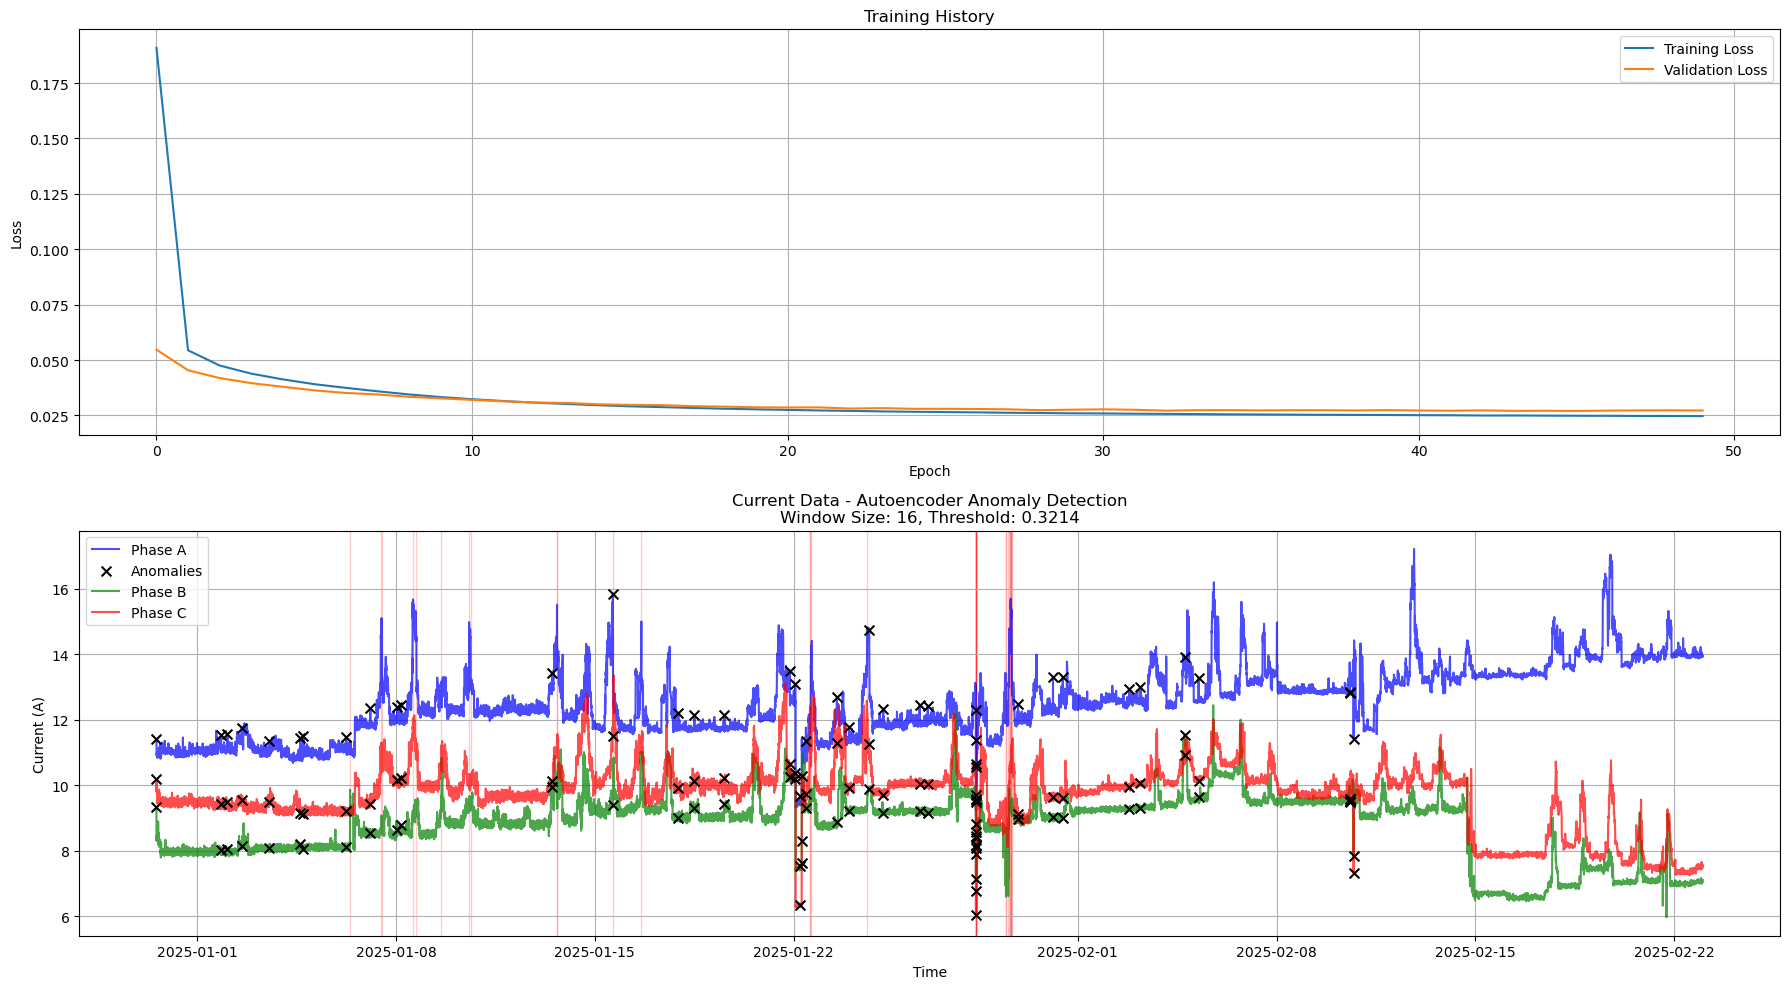


Final Model Performance:
- Precision: 0.0930
- Recall: 0.1250
- F1-score: 0.1067
- Threshold: 0.3214
- Anomalies Detected: 43


In [36]:
# After running your model selection code that produces results_df
best_model_info = results_df.loc[results_df['F1-score'].idxmax()]
best_window_current = best_model_info['Window Size']
best_model_current = best_model_info['Model']

# Prepare windowed data from COMBINED dataset
df_ups_i = df_combined_i[i_cols].copy()
df_ups_i_win = window_dataframe(df_combined_i[i_cols + ['data_hora']], window_size=best_window_current)
df_ups_i_win_plot = df_ups_i_win.copy()

# Calculate window means
i_phases_clean = ['ups_ia_out','ups_ib_out','ups_ic_out']

for phase in i_phases_clean:  # i_phases_clean = ['ups_ia_out', 'ups_ib_out', 'ups_ic_out']
    cols = [f"{phase}-t-{i+1}" for i in range(best_window_current)]
    df_ups_i_win_plot[f"{phase}_mean"] = df_ups_i_win_plot[cols].mean(axis=1)

# Train-test split (using same dates as before)
test_start_current = pd.to_datetime('2024-12-29')
test_end_current = pd.to_datetime('2025-02-23')
test_mask_current = (df_ups_i_win_plot.index >= test_start_current) & (df_ups_i_win_plot.index <= test_end_current)
df_test_current = df_ups_i_win_plot[test_mask_current].copy()
df_train_current = df_ups_i_win_plot[~test_mask_current].copy()

# Prepare features (exclude mean columns)
X_train_current = df_train_current.drop(columns=[c for c in df_train_current.columns if c.endswith('_mean')])
X_test_current = df_test_current.drop(columns=[c for c in df_test_current.columns if c.endswith('_mean')])

# === Enhanced Model Building ===
def build_enhanced_autoencoder(input_dim):
    model = Sequential([
        Dense(128, input_shape=(input_dim,), kernel_regularizer=regularizers.l2(1e-4)),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        Dense(64, kernel_regularizer=regularizers.l2(1e-4)),
        LeakyReLU(alpha=0.1),
        Dense(32, kernel_regularizer=regularizers.l2(1e-4)),
        LeakyReLU(alpha=0.1),
        Dense(16, kernel_regularizer=regularizers.l2(1e-4)),
        LeakyReLU(alpha=0.1),
        Dense(32),
        LeakyReLU(alpha=0.1),
        Dense(64),
        LeakyReLU(alpha=0.1),
        Dense(input_dim, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return model

def build_enhanced_lstm(seq_len, n_features):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(seq_len, n_features)),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        RepeatVector(seq_len),
        LSTM(32, return_sequences=True),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        LSTM(128, return_sequences=True),
        LeakyReLU(alpha=0.1),
        TimeDistributed(Dense(n_features))
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return model

# === Train Best Model ===
if best_model_current == "Autoencoder":
    scaler_current = StandardScaler()
    X_train_current_scaled = scaler_current.fit_transform(X_train_current)
    X_test_current_scaled = scaler_current.transform(X_test_current)

    model_current = build_enhanced_autoencoder(X_train_current_scaled.shape[1])
    history = model_current.fit(
        X_train_current_scaled, X_train_current_scaled,
        epochs=50, batch_size=32, validation_split=0.1,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=1
    )

    recon_current = model_current.predict(X_test_current_scaled)
    errors_current = np.mean(np.square(X_test_current_scaled - recon_current), axis=1)

else:  # LSTM
    scaler_current = MinMaxScaler()
    X_train_current_scaled = scaler_current.fit_transform(X_train_current)
    X_test_current_scaled = scaler_current.transform(X_test_current)

    n_features_current = 3
    X_train_current_seq = X_train_current_scaled.reshape(-1, best_window_current, n_features_current)
    X_test_current_seq = X_test_current_scaled.reshape(-1, best_window_current, n_features_current)

    model_current = build_enhanced_lstm(best_window_current, n_features_current)
    history = model_current.fit(
        X_train_current_seq, X_train_current_seq,
        epochs=50, batch_size=32, validation_split=0.1,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=1
    )

    recon_seq_current = model_current.predict(X_test_current_seq)
    errors_current = np.mean(np.square(X_test_current_seq - recon_seq_current), axis=(1, 2))

# Dynamic threshold selection
threshold_current = np.percentile(errors_current, 99.8)
anomalies_current = errors_current > threshold_current

# Add results to test dataframe
df_test_current['anomaly_score'] = errors_current
df_test_current['predicted_label'] = anomalies_current.astype(int)

# === Visualization ===
plt.figure(figsize=(18, 10))

# Plot training history if available
if 'history' in locals():
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

# Plot anomaly detection results
ax = plt.subplot(2, 1, 2) if 'history' in locals() else plt.subplot(1, 1, 1)

current_labels = ['Phase A', 'Phase B', 'Phase C']
colors = ['blue', 'green', 'red']

for phase, label, color in zip(i_phases_clean, current_labels, colors):
    ax.plot(df_test_current.index, df_test_current[f"{phase}_mean"],
            label=label, alpha=0.7, color=color)

    # Plot anomalies
    anomalies = df_test_current[df_test_current['predicted_label'] == 1]
    ax.scatter(
        anomalies.index,
        anomalies[f"{phase}_mean"],
        color='black', marker='x', s=50, zorder=10,
        label='Anomalies' if phase == i_phases_clean[0] else ""
    )

# Highlight supervisor-labeled anomalies
for interval in supervisor_anomalies_i:
    ax.axvspan(interval[0], interval[1], color='red', alpha=0.2)

ax.set_title(f"Current Data - {best_model_current} Anomaly Detection\nWindow Size: {best_window_current}, Threshold: {threshold_current:.4f}")
ax.set_xlabel("Time")
ax.set_ylabel("Current (A)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# === Performance Metrics ===
detected_anomalies = df_test_current.index[df_test_current['predicted_label'] == 1]
p, r, f1 = compare_anomalies_with_metrics(detected_anomalies, supervisor_anomalies_i, df_test_current.index)

print("\nFinal Model Performance:")
print(f"- Precision: {p:.4f}")
print(f"- Recall: {r:.4f}")
print(f"- F1-score: {f1:.4f}")
print(f"- Threshold: {threshold_current:.4f}")
print(f"- Anomalies Detected: {len(detected_anomalies)}")

In [37]:
# Compare to supervisor labels
predicted_anomaly_indices_current = df_test_current.index[df_test_current['predicted_label'] == 1]
tp_current, fp_current, fn_current = compare_anomalies(predicted_anomaly_indices_current, supervisor_anomalies_i)

# Create and display summary
summary_i = pd.DataFrame({
    "Model": [best_model_current],
    "Window Size": [best_window_current],
    "Total Detected": [len(predicted_anomaly_indices_current)],
    "True Positives": [len(tp_current)],
    "False Positives": [len(fp_current)],
    "False Negatives": [len(fn_current)],
})

print("\nAnomaly Detection Performance Summary (UPS_I):")
summary_i


Anomaly Detection Performance Summary (UPS_I):


,Model,Window Size,Total Detected,True Positives,False Positives,False Negatives
0,Autoencoder,16,43,4,39,28


In [38]:
# Print detailed results
print("\nDetailed Results (Current Data):")
print(f"Total anomalies detected: {len(predicted_anomaly_indices_current)}")
print(f"True positives: {len(tp_current)}")
print(f"False positives: {len(fp_current)}")
print(f"False negatives: {len(fn_current)}")

# Print the actual timestamps of anomalies
print("\nDetected Anomaly Timestamps (Current Data):")
print(predicted_anomaly_indices_current)

# Print supervisor's anomaly intervals that were missed (false negatives)
if len(fn_current) > 0:
    print("\nMissed Anomaly Intervals (False Negatives - Current Data):")
    for interval in fn_current:
        print(f"From {interval[0]} to {interval[1]}")
else:
    print("\nNo missed anomalies (all supervisor intervals detected)")


Detailed Results (Current Data):
Total anomalies detected: 43
True positives: 4
False positives: 39
False negatives: 28

Detected Anomaly Timestamps (Current Data):
DatetimeIndex(['2024-12-30 13:45:05', '2025-01-01 20:17:48',
               '2025-01-02 01:40:05', '2025-01-02 13:46:32',
               '2025-01-03 13:02:04', '2025-01-04 15:21:10',
               '2025-01-04 17:55:39', '2025-01-06 06:08:11',
               '2025-01-07 02:24:26', '2025-01-08 01:13:40',
               '2025-01-08 04:01:36', '2025-01-13 11:54:30',
               '2025-01-15 15:16:13', '2025-01-17 22:36:54',
               '2025-01-18 12:10:41', '2025-01-19 13:35:53',
               '2025-01-21 20:34:16', '2025-01-22 01:21:28',
               '2025-01-22 05:47:04', '2025-01-22 06:51:10',
               '2025-01-22 10:28:55', '2025-01-23 12:33:17',
               '2025-01-23 22:44:42', '2025-01-24 15:47:29',
               '2025-01-25 03:44:01', '2025-01-26 10:24:08',
               '2025-01-26 17:17:02', '20

### Saving the model

In [39]:
from joblib import dump
from tensorflow.keras.models import save_model
import os

# === Step 1: Définir un dossier local (ex: projet dans ton home dir ou un dossier spécifique) ===
base_dir = "anomaly_detection_project"  # ou un chemin complet, ex: "C:/Users/TonNom/Documents/anomaly_detection_project"

# Sous-dossiers par type de mesure
subset_dirs = {
    "UPS_V": os.path.join(base_dir, "UPS_V"),
    "UPS_P": os.path.join(base_dir, "UPS_P"),
    "UPS_I": os.path.join(base_dir, "UPS_I"),
    "UPS_bat": os.path.join(base_dir, "UPS_bat")
}

# Créer les dossiers si besoin
for dir_path in subset_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# === Step 2: Sauvegarder le modèle et le scaler ===
save_model(model_volt, os.path.join(subset_dirs["UPS_I"], "autoencoder_model.keras"))
dump(scaler_volt, os.path.join(subset_dirs["UPS_I"], "scaler.pkl"))

# === Step 3: Sauvegarder les résultats (si `voltage_summary` existe) ===
summary_i.to_csv(os.path.join(subset_dirs["UPS_I"], "summary.csv"), index=False)

In [40]:
import os
from tensorflow.keras.models import load_model
from joblib import load

# === Base path local ===
base_dir = "anomaly_detection_project"  # ou un chemin absolu comme "C:/Users/TonNom/Documents/anomaly_detection_project"

# === Nom du sous-dossier (doit correspondre à la sauvegarde précédente) ===
subset = "UPS_I"  # <- par exemple, pour voltage

# === Construction des chemins ===
model_path = os.path.join(base_dir, subset, "autoencoder_model.keras")
scaler_path = os.path.join(base_dir, subset, "scaler.pkl")

# === Chargement ===
model = load_model(model_path)
scaler = load(scaler_path)

print("✅ Model and scaler loaded successfully!")

✅ Model and scaler loaded successfully!


## UPS_P

In [41]:
# Extract current data from original dataset with timestamps
df_ups_p_original = df_ups[['data_hora', 'ups_pa', 'ups_pb', 'ups_pc', 'ups_sa', 'ups_sb', 'ups_sc']].copy()

# Ensure the timestamp is in datetime format
df_ups_p_original['data_hora'] = pd.to_datetime(df_ups_p_original['data_hora'])

In [42]:
df_ups_p_original.head()

,data_hora,ups_pa,ups_pb,ups_pc,ups_sa,ups_sb,ups_sc
0,2024-10-31 20:31:19,2949.0,1613.0,1780.0,3524.0,1819.0,2063.0
1,2024-10-31 20:31:29,2958.0,1591.0,1630.0,3580.0,1819.0,2063.0
2,2024-10-31 20:31:39,3014.0,1620.0,1589.0,3707.0,1821.0,2123.0
3,2024-10-31 20:31:49,2966.0,1625.0,1678.0,3524.0,1821.0,2005.0
4,2024-10-31 20:32:00,2998.0,1647.0,1676.0,3517.0,1883.0,2126.0


In [43]:
df_ups_i_original.shape

(704248, 4)

In [44]:
import pandas as pd
import os

file_path_ups_p = 'ups_p.csv'  

# Lecture du fichier CSV
try:
    df_ups_p = pd.read_csv(file_path_ups_p)
    print("File loaded successfully!")

    # Affichage des premières lignes
    print("\nFirst 5 rows of the dataframe:")
    print(df_ups_p.head())

except FileNotFoundError:
    print(f"❌ File not found at path: {file_path_ups_p}")
except Exception as e:
    print(f"⚠️ An error occurred: {str(e)}")

File loaded successfully!

First 5 rows of the dataframe:
                        time  ups_pa  ups_pb  ups_pc
0  2025-02-01 00:00:00+00:00  2410.5  1638.5  1725.5
1  2025-02-01 00:00:20+00:00  2429.0  1605.0  1730.5
2  2025-02-01 00:00:40+00:00  2448.0  1704.5  1712.0
3  2025-02-01 00:01:00+00:00  2426.5  1659.0  1695.5
4  2025-02-01 00:01:20+00:00  2417.0  1670.0  1712.5


In [45]:
# Rename Columns and Convert timestamp 
df_ups_p = df_ups_p.rename(columns={
    'time':'data_hora' 
})
df_ups_p['data_hora']= pd.to_datetime(df_ups_p['data_hora']).dt.tz_localize(None)

df_ups_p.head()

,data_hora,ups_pa,ups_pb,ups_pc
0,2025-02-01 00:00:00,2410.5,1638.5,1725.5
1,2025-02-01 00:00:20,2429.0,1605.0,1730.5
2,2025-02-01 00:00:40,2448.0,1704.5,1712.0
3,2025-02-01 00:01:00,2426.5,1659.0,1695.5
4,2025-02-01 00:01:20,2417.0,1670.0,1712.5


In [46]:
df_ups_p.shape

(612941, 4)

In [47]:
# Combine both datasets
df_combined_p = pd.concat([df_ups_p_original, df_ups_p])

# Sort by timestamp
df_combined_p = df_combined_p.sort_values('data_hora').reset_index(drop=True)

# Check for duplicates and remove them
df_combined_p = df_combined_p.drop_duplicates(subset='data_hora', keep='first')

In [48]:
df_combined_p.shape

(1317125, 7)

In [49]:
df_combined_p.head()

,data_hora,ups_pa,ups_pb,ups_pc,ups_sa,ups_sb,ups_sc
0,2024-10-31 20:31:19,2949.0,1613.0,1780.0,3524.0,1819.0,2063.0
1,2024-10-31 20:31:29,2958.0,1591.0,1630.0,3580.0,1819.0,2063.0
2,2024-10-31 20:31:39,3014.0,1620.0,1589.0,3707.0,1821.0,2123.0
3,2024-10-31 20:31:49,2966.0,1625.0,1678.0,3524.0,1821.0,2005.0
4,2024-10-31 20:32:00,2998.0,1647.0,1676.0,3517.0,1883.0,2126.0


In [93]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# === Supervisor anomaly intervals ===
supervisor_anomalies_p = [
    (pd.Timestamp('2025-01-06 09:11'), pd.Timestamp('2025-01-06 09:14')),
    (pd.Timestamp('2025-01-09 14:26'), pd.Timestamp('2025-01-09 14:29')),
    (pd.Timestamp('2025-01-29 11:18'), pd.Timestamp('2025-01-29 11:21')),
    (pd.Timestamp('2025-01-29 11:40'), pd.Timestamp('2025-01-29 11:44')),
    (pd.Timestamp('2025-01-29 13:10'), pd.Timestamp('2025-01-29 13:14')),
    (pd.Timestamp('2025-01-29 13:45'), pd.Timestamp('2025-01-29 13:51')),
    (pd.Timestamp('2025-01-22 13:42'), pd.Timestamp('2025-01-22 13:44')),
    (pd.Timestamp('2025-01-22 13:42'), pd.Timestamp('2025-01-22 13:44')),
    (pd.Timestamp('2025-01-28 09:53'), pd.Timestamp('2025-01-28 09:54')),
    (pd.Timestamp('2025-01-28 09:55'), pd.Timestamp('2025-01-28 09:57')),
    (pd.Timestamp('2025-01-28 09:57'), pd.Timestamp('2025-01-28 09:59')),
    (pd.Timestamp('2025-01-28 10:02'), pd.Timestamp('2025-01-28 10:04')),
    (pd.Timestamp('2025-01-28 10:04'), pd.Timestamp('2025-01-28 10:06')),
    (pd.Timestamp('2025-01-28 10:05'), pd.Timestamp('2025-01-28 10:07')),
    (pd.Timestamp('2025-01-28 10:14'), pd.Timestamp('2025-01-28 10:16')),
    (pd.Timestamp('2025-01-07 11:07'), pd.Timestamp('2025-01-07 11:09')),
    (pd.Timestamp('2025-01-07 12:12'), pd.Timestamp('2025-01-07 12:16')),
    (pd.Timestamp('2025-01-08 14:03'), pd.Timestamp('2025-01-08 14:07')),
    (pd.Timestamp('2025-01-08 17:19'), pd.Timestamp('2025-01-08 17:23')),
    (pd.Timestamp('2025-01-10 13:46'), pd.Timestamp('2025-01-10 13:48')),
    (pd.Timestamp('2025-01-10 15:10'), pd.Timestamp('2025-01-10 15:11')),
    (pd.Timestamp('2025-01-13 16:04'), pd.Timestamp('2025-01-13 16:07')),
    (pd.Timestamp('2025-01-13 16:07'), pd.Timestamp('2025-01-13 16:09')),
    (pd.Timestamp('2025-01-15 15:20'), pd.Timestamp('2025-01-15 15:23')),
    (pd.Timestamp('2025-01-16 15:20'), pd.Timestamp('2025-01-16 15:27')),
    (pd.Timestamp('2025-01-22 14:27'), pd.Timestamp('2025-01-22 14:29')),
    (pd.Timestamp('2025-01-29 15:26'), pd.Timestamp('2025-01-29 15:27')),
    (pd.Timestamp('2025-01-24 13:58'), pd.Timestamp('2025-01-24 14:03')),
    (pd.Timestamp('2025-01-29 15:00'), pd.Timestamp('2025-01-29 15:02')),
    (pd.Timestamp('2025-01-29 15:32'), pd.Timestamp('2025-01-29 15:35')),
    (pd.Timestamp('2025-01-29 15:05'), pd.Timestamp('2025-01-29 15:08')),
    (pd.Timestamp('2025-01-29 16:03'), pd.Timestamp('2025-01-29 16:18'))
]    

def is_true_positive(ts, intervals):
    return any(start <= ts <= end for start, end in intervals)

def compare_anomalies_with_metrics(detected_indices, intervals, all_timestamps):
    y_true = np.array([1 if is_true_positive(ts, intervals) else 0 for ts in all_timestamps])
    y_pred = np.array([1 if ts in detected_indices else 0 for ts in all_timestamps])
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return precision, recall, f1

def window_dataframe(df, window_size, timestamp_col='data_hora'):
    features = df.drop(columns=[timestamp_col]).values
    n_rows = features.shape[0]
    n_windows = n_rows // window_size

    windowed_features = features[:n_windows * window_size].reshape(n_windows, window_size, -1)
    window_timestamps = df[timestamp_col].iloc[(window_size - 1)::window_size].values[:n_windows]

    new_columns = []
    for col in df.columns:
        if col != timestamp_col:
            new_columns += [f"{col}-t-{i+1}" for i in range(window_size)]

    windowed_data = windowed_features.transpose(0, 2, 1).reshape(n_windows, -1)
    windowed_df = pd.DataFrame(windowed_data, columns=new_columns)
    windowed_df['window_time'] = pd.to_datetime(window_timestamps)
    windowed_df = windowed_df.set_index('window_time')

    # ✅ Drop any NaN rows after windowing
    windowed_df = windowed_df.dropna()

    return windowed_df

def build_autoencoder(input_dim, hidden_dims=[64, 32, 16], l2_reg=1e-8, dropout_rate=0.1, leaky_alpha=0.1):
    model = Sequential()
    for dim in hidden_dims:
        model.add(Dense(dim, kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(LeakyReLU(alpha=leaky_alpha))
        model.add(Dropout(dropout_rate))
    for dim in reversed(hidden_dims[:-1]):
        model.add(Dense(dim))
        model.add(LeakyReLU(alpha=leaky_alpha))
    model.add(Dense(input_dim, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return model

def build_lstm_autoencoder(seq_len, n_features, encoder_dims=[64, 32], decoder_dims=[32, 64], dropout_rate=0.2, leaky_alpha=0.1):
    model = Sequential()
    for i, units in enumerate(encoder_dims):
        return_sequences = i < len(encoder_dims) - 1
        model.add(LSTM(units, return_sequences=return_sequences,
                       input_shape=(seq_len, n_features) if i == 0 else None))
        model.add(LeakyReLU(alpha=leaky_alpha))
        model.add(Dropout(dropout_rate))
    model.add(RepeatVector(seq_len))
    for units in decoder_dims:
        model.add(LSTM(units, return_sequences=True))
        model.add(LeakyReLU(alpha=leaky_alpha))
        model.add(Dropout(dropout_rate))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return model

# === Main Training Loop ===
results_current = []
window_sizes = [12, 16, 25]
p_cols = ['ups_pa', 'ups_pb', 'ups_pc', 'ups_sa', 'ups_sb', 'ups_sc']

for window_size in window_sizes:
    print(f"\n=== Window size: {window_size} ===")

    df_win = window_dataframe(df_combined_p[p_cols + ['data_hora']].copy(), window_size)
    print(f"Shape après window_dataframe : {df_win.shape}")

    # Train/test split
    test_mask = (df_win.index >= "2024-12-29") & (df_win.index <= "2025-02-23")
    df_test = df_win[test_mask]
    df_train = df_win[~test_mask]

    X_train = df_train.copy()
    X_test = df_test.copy()
    all_ts = df_test.index

    # Vérif NaN
    print(f"NaN in X_train: {X_train.isna().sum().sum()}")
    print(f"NaN in X_test: {X_test.isna().sum().sum()}")

    assert X_train.isna().sum().sum() == 0, "X_train still has NaN!"
    assert X_test.isna().sum().sum() == 0, "X_test still has NaN!"

    # === Autoencoder ===
    scaler_ae = StandardScaler()
    X_train_ae = scaler_ae.fit_transform(X_train)
    X_test_ae = scaler_ae.transform(X_test)

    print(f"NaN in X_train_ae: {np.isnan(X_train_ae).sum()}")
    print(f"NaN in X_test_ae: {np.isnan(X_test_ae).sum()}")

    ae_model = build_autoencoder(X_train_ae.shape[1])
    ae_model.fit(X_train_ae, X_train_ae, epochs=30, batch_size=32, validation_split=0.1,
                 callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)

    ae_recon = ae_model.predict(X_test_ae)
    ae_err = np.mean((X_test_ae - ae_recon)**2, axis=1)
    ae_thresh = np.percentile(ae_err, 99.5)
    ae_anomalies = all_ts[ae_err > ae_thresh]
    p_ae, r_ae, f_ae = compare_anomalies_with_metrics(ae_anomalies, supervisor_anomalies_p, all_ts)

    results_current.append({
        "Model": "Autoencoder", "Window Size": window_size,
        "Threshold": ae_thresh, "Total Detected": len(ae_anomalies),
        "Precision": p_ae, "Recall": r_ae, "F1-score": f_ae
    })

    # === LSTM ===
    scaler_lstm = MinMaxScaler()
    X_train_lstm = scaler_lstm.fit_transform(X_train)
    X_test_lstm = scaler_lstm.transform(X_test)

    X_train_seq = X_train_lstm.reshape(-1, window_size, 6)
    X_test_seq = X_test_lstm.reshape(-1, window_size, 6)

    lstm_model = build_lstm_autoencoder(window_size, 6)
    lstm_model.fit(X_train_seq, X_train_seq, epochs=30, batch_size=32, validation_split=0.1,
                   callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)

    lstm_recon = lstm_model.predict(X_test_seq)
    lstm_err = np.mean((X_test_seq - lstm_recon)**2, axis=(1, 2))
    lstm_thresh = np.percentile(lstm_err, 99.5)
    lstm_anomalies = all_ts[lstm_err > lstm_thresh]
    p_lstm, r_lstm, f_lstm = compare_anomalies_with_metrics(lstm_anomalies, supervisor_anomalies_p, all_ts)

    results_current.append({
        "Model": "LSTM", "Window Size": window_size,
        "Threshold": lstm_thresh, "Total Detected": len(lstm_anomalies),
        "Precision": p_lstm, "Recall": r_lstm, "F1-score": f_lstm
    })

# Résultats finaux
results_df = pd.DataFrame(results_current)
best_model = results_df.loc[results_df['F1-score'].idxmax()]
print("\n=== Best Performing Model ===")
print(best_model)
print("\n=== Complete Results ===")
display(results_df.sort_values(['Model', 'Window Size']))



=== Window size: 12 ===
Shape après window_dataframe : (58589, 72)
NaN in X_train: 0
NaN in X_test: 0
NaN in X_train_ae: 0
NaN in X_test_ae: 0


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

=== Window size: 16 ===
Shape après window_dataframe : (43941, 96)
NaN in X_train: 0
NaN in X_test: 0
NaN in X_train_ae: 0
NaN in X_test_ae: 0


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

=== Window size: 25 ===
Shape après window_dataframe : (28122, 150)
NaN in X_train: 0
NaN in X_test: 0
NaN in X_train_ae: 0
NaN in X_test_ae: 0


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step

=== Best Performing Model ===
Model             Autoencoder
Window Size                16
Threshold            1.277787
Total Detected             83
Precision            0.036145
Recall                0.09375
F1-score             0.052174
Name: 2, dtype: object

=== Complete Results ===


,Model,Window Size,Threshold,Total Detected,Precision,Recall,F1-score
0,Autoencoder,12,1.287799,111,0.018018,0.044444,0.025641
2,Autoencoder,16,1.277787,83,0.036145,0.093750,0.052174
4,Autoencoder,25,2.061601,53,0.000000,0.000000,0.000000
1,LSTM,12,0.074613,111,0.009009,0.022222,0.012821
3,LSTM,16,0.080835,83,0.024096,0.062500,0.034783
5,LSTM,25,0.095712,53,0.018868,0.043478,0.026316


Epoch 1/50


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5463 - val_loss: 0.1050
Epoch 2/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0923 - val_loss: 0.0663
Epoch 3/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0668 - val_loss: 0.0584
Epoch 4/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0523 - val_loss: 0.0495
Epoch 5/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0455 - val_loss: 0.0463
Epoch 6/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0425 - val_loss: 0.0445
Epoch 7/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0404 - val_loss: 0.0436
Epoch 8/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0386 - val_loss: 0.0426
Epoch 9/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0369 - val_loss: 0.0429
Epoch 10/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0356 - val_loss: 0.0423
Epoch 11/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0343 - val_loss: 0.0400
Epoch 12/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.

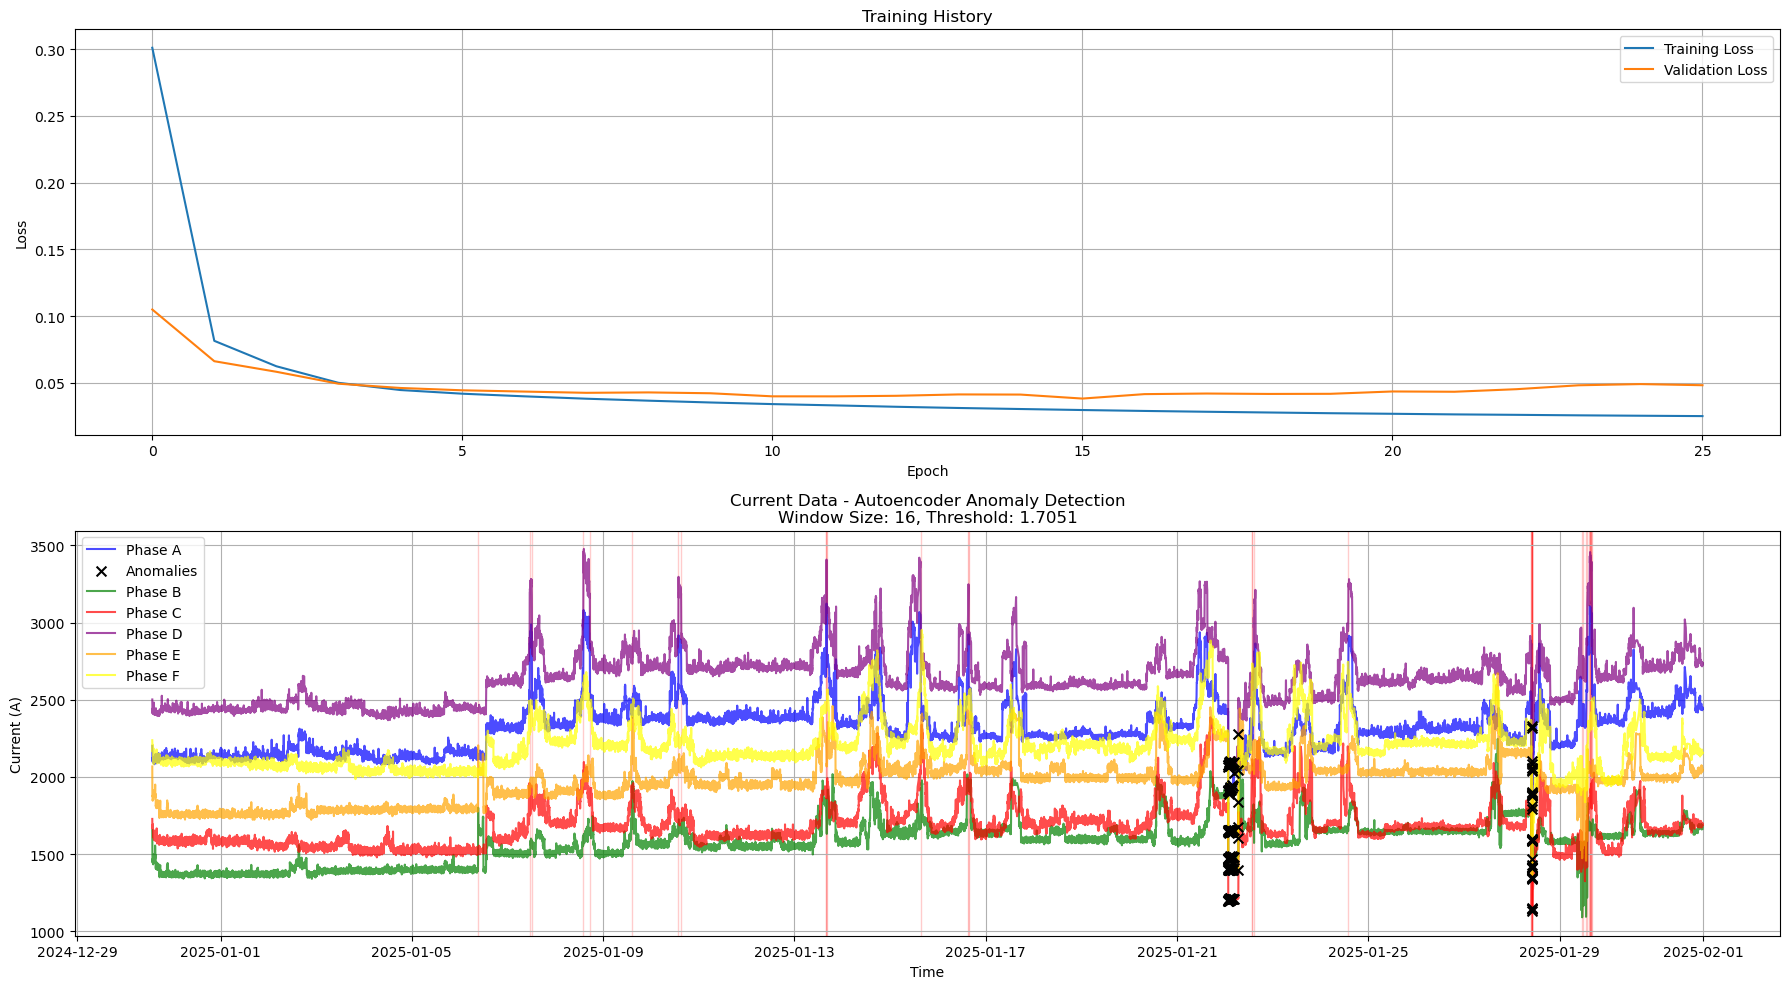


Final Model Performance:
- Precision: 0.0588
- Recall: 0.0625
- F1-score: 0.0606
- Threshold: 1.7051
- Anomalies Detected: 34


In [97]:
# After running your model selection code that produces results_df
best_model_info = results_df.loc[results_df['F1-score'].idxmax()]
best_window_current = best_model_info['Window Size']
best_model_current = best_model_info['Model']

# Prepare windowed data from COMBINED dataset
df_ups_p = df_combined_p[p_cols].copy()
df_ups_p_win = window_dataframe(df_combined_p[p_cols + ['data_hora']], window_size=best_window_current)
df_ups_p_win_plot = df_ups_p_win.copy()

# Calculate window means
p_phases_clean = ['ups_pa', 'ups_pb', 'ups_pc', 'ups_sa', 'ups_sb', 'ups_sc']

for phase in p_phases_clean: 
    cols = [f"{phase}-t-{i+1}" for i in range(best_window_current)]
    df_ups_p_win_plot[f"{phase}_mean"] = df_ups_p_win_plot[cols].mean(axis=1)

# Train-test split (using same dates as before)
test_start_current = pd.to_datetime('2024-12-29')
test_end_current = pd.to_datetime('2025-02-23')
test_mask_current = (df_ups_p_win_plot.index >= test_start_current) & (df_ups_p_win_plot.index <= test_end_current)
df_test_current = df_ups_p_win_plot[test_mask_current].copy()
df_train_current = df_ups_p_win_plot[~test_mask_current].copy()

# Prepare features (exclude mean columns)
X_train_current = df_train_current.drop(columns=[c for c in df_train_current.columns if c.endswith('_mean')])
X_test_current = df_test_current.drop(columns=[c for c in df_test_current.columns if c.endswith('_mean')])

# === Enhanced Model Building ===
def build_enhanced_autoencoder(input_dim):
    model = Sequential([
        Dense(128, input_shape=(input_dim,), kernel_regularizer=regularizers.l2(1e-4)),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        Dense(64, kernel_regularizer=regularizers.l2(1e-4)),
        LeakyReLU(alpha=0.1),
        Dense(32, kernel_regularizer=regularizers.l2(1e-4)),
        LeakyReLU(alpha=0.1),
        Dense(16, kernel_regularizer=regularizers.l2(1e-4)),
        LeakyReLU(alpha=0.1),
        Dense(32),
        LeakyReLU(alpha=0.1),
        Dense(64),
        LeakyReLU(alpha=0.1),
        Dense(input_dim, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return model

def build_enhanced_lstm(seq_len, n_features):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(seq_len, n_features)),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        RepeatVector(seq_len),
        LSTM(32, return_sequences=True),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        LSTM(128, return_sequences=True),
        LeakyReLU(alpha=0.1),
        TimeDistributed(Dense(n_features))
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return model

# === Train Best Model ===
if best_model_current == "Autoencoder":
    scaler_current = StandardScaler()
    X_train_current_scaled = scaler_current.fit_transform(X_train_current)
    X_test_current_scaled = scaler_current.transform(X_test_current)

    model_current = build_enhanced_autoencoder(X_train_current_scaled.shape[1])
    history = model_current.fit(
        X_train_current_scaled, X_train_current_scaled,
        epochs=50, batch_size=32, validation_split=0.1,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=1
    )

    recon_current = model_current.predict(X_test_current_scaled)
    errors_current = np.mean(np.square(X_test_current_scaled - recon_current), axis=1)

else:  # LSTM
    scaler_current = MinMaxScaler()
    X_train_current_scaled = scaler_current.fit_transform(X_train_current)
    X_test_current_scaled = scaler_current.transform(X_test_current)

    n_features_current = 6
    X_train_current_seq = X_train_current_scaled.reshape(-1, best_window_current, n_features_current)
    X_test_current_seq = X_test_current_scaled.reshape(-1, best_window_current, n_features_current)

    model_current = build_enhanced_lstm(best_window_current, n_features_current)
    history = model_current.fit(
        X_train_current_seq, X_train_current_seq,
        epochs=50, batch_size=32, validation_split=0.1,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=1
    )

    recon_seq_current = model_current.predict(X_test_current_seq)
    errors_current = np.mean(np.square(X_test_current_seq - recon_seq_current), axis=(1, 2))

# Dynamic threshold selection
threshold_current = np.percentile(errors_current, 99.8)
anomalies_current = errors_current > threshold_current

# Add results to test dataframe
df_test_current['anomaly_score'] = errors_current
df_test_current['predicted_label'] = anomalies_current.astype(int)

# === Visualization ===
plt.figure(figsize=(18, 10))

# Plot training history if available
if 'history' in locals():
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

# Plot anomaly detection results
ax = plt.subplot(2, 1, 2) if 'history' in locals() else plt.subplot(1, 1, 1)

current_labels = ['Phase A', 'Phase B', 'Phase C', 'Phase D', 'Phase E', 'Phase F']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow']

for phase, label, color in zip(p_phases_clean, current_labels, colors):
    ax.plot(df_test_current.index, df_test_current[f"{phase}_mean"],
            label=label, alpha=0.7, color=color)

    # Plot anomalies
    anomalies = df_test_current[df_test_current['predicted_label'] == 1]
    ax.scatter(
        anomalies.index,
        anomalies[f"{phase}_mean"],
        color='black', marker='x', s=50, zorder=10,
        label='Anomalies' if phase == p_phases_clean[0] else ""
    )

# Highlight supervisor-labeled anomalies
for interval in supervisor_anomalies_p:
    ax.axvspan(interval[0], interval[1], color='red', alpha=0.2)

ax.set_title(f"Current Data - {best_model_current} Anomaly Detection\nWindow Size: {best_window_current}, Threshold: {threshold_current:.4f}")
ax.set_xlabel("Time")
ax.set_ylabel("Current (A)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# === Performance Metrics ===
detected_anomalies = df_test_current.index[df_test_current['predicted_label'] == 1]
p, r, f1 = compare_anomalies_with_metrics(detected_anomalies, supervisor_anomalies_p, df_test_current.index)

print("\nFinal Model Performance:")
print(f"- Precision: {p:.4f}")
print(f"- Recall: {r:.4f}")
print(f"- F1-score: {f1:.4f}")
print(f"- Threshold: {threshold_current:.4f}")
print(f"- Anomalies Detected: {len(detected_anomalies)}")

In [98]:
# Compare to supervisor labels
predicted_anomaly_indices_current = df_test_current.index[df_test_current['predicted_label'] == 1]
tp_current, fp_current, fn_current = compare_anomalies(predicted_anomaly_indices_current, supervisor_anomalies_p)

# Create and display summary
summary_p = pd.DataFrame({
    "Model": [best_model_current],
    "Window Size": [best_window_current],
    "Total Detected": [len(predicted_anomaly_indices_current)],
    "True Positives": [len(tp_current)],
    "False Positives": [len(fp_current)],
    "False Negatives": [len(fn_current)],
})

print("\nAnomaly Detection Performance Summary (UPS_P):")
summary_p


Anomaly Detection Performance Summary (UPS_P):


,Model,Window Size,Total Detected,True Positives,False Positives,False Negatives
0,Autoencoder,16,34,2,32,30


In [99]:
# Print detailed results
print("\nDetailed Results (Current Data):")
print(f"Total anomalies detected: {len(predicted_anomaly_indices_current)}")
print(f"True positives: {len(tp_current)}")
print(f"False positives: {len(fp_current)}")
print(f"False negatives: {len(fn_current)}")

# Print the actual timestamps of anomalies
print("\nDetected Anomaly Timestamps (Current Data):")
print(predicted_anomaly_indices_current)

# Print supervisor's anomaly intervals that were missed (false negatives)
if len(fn_current) > 0:
    print("\nMissed Anomaly Intervals (False Negatives - Current Data):")
    for interval in fn_current:
        print(f"From {interval[0]} to {interval[1]}")
else:
    print("\nNo missed anomalies (all supervisor intervals detected)")


Detailed Results (Current Data):
Total anomalies detected: 34
True positives: 2
False positives: 32
False negatives: 30

Detected Anomaly Timestamps (Current Data):
DatetimeIndex(['2025-01-22 01:45:07', '2025-01-22 01:47:52',
               '2025-01-22 01:50:37', '2025-01-22 01:53:22',
               '2025-01-22 01:56:07', '2025-01-22 01:58:51',
               '2025-01-22 02:01:36', '2025-01-22 02:07:12',
               '2025-01-22 02:09:57', '2025-01-22 02:18:11',
               '2025-01-22 02:20:56', '2025-01-22 02:26:25',
               '2025-01-22 02:29:10', '2025-01-22 02:31:55',
               '2025-01-22 02:34:40', '2025-01-22 02:37:25',
               '2025-01-22 02:40:10', '2025-01-22 02:42:54',
               '2025-01-22 02:45:39', '2025-01-22 02:48:25',
               '2025-01-22 02:51:10', '2025-01-22 02:53:55',
               '2025-01-22 02:59:24', '2025-01-22 03:46:10',
               '2025-01-22 03:51:40', '2025-01-22 03:57:10',
               '2025-01-22 04:24:42', '20

### Saving Model

In [100]:
from joblib import dump
from tensorflow.keras.models import save_model
import os

# === Step 1: Définir un dossier local (ex: projet dans ton home dir ou un dossier spécifique) ===
base_dir = "anomaly_detection_project"  # ou un chemin complet, ex: "C:/Users/TonNom/Documents/anomaly_detection_project"

# Sous-dossiers par type de mesure
subset_dirs = {
    "UPS_V": os.path.join(base_dir, "UPS_V"),
    "UPS_P": os.path.join(base_dir, "UPS_P"),
    "UPS_I": os.path.join(base_dir, "UPS_I"),
    "UPS_bat": os.path.join(base_dir, "UPS_bat")
}

# Créer les dossiers si besoin
for dir_path in subset_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# === Step 2: Sauvegarder le modèle et le scaler ===
save_model(model_volt, os.path.join(subset_dirs["UPS_P"], "autoencoder_model.keras"))
dump(scaler_volt, os.path.join(subset_dirs["UPS_P"], "scaler.pkl"))

# === Step 3: Sauvegarder les résultats (si `voltage_summary` existe) ===
summary_i.to_csv(os.path.join(subset_dirs["UPS_P"], "summary.csv"), index=False)

In [101]:
import os
from tensorflow.keras.models import load_model
from joblib import load

# === Base path local ===
base_dir = "anomaly_detection_project"  # ou un chemin absolu comme "C:/Users/TonNom/Documents/anomaly_detection_project"

# === Nom du sous-dossier (doit correspondre à la sauvegarde précédente) ===
subset = "UPS_P"  # <- par exemple, pour voltage

# === Construction des chemins ===
model_path = os.path.join(base_dir, subset, "autoencoder_model.keras")
scaler_path = os.path.join(base_dir, subset, "scaler.pkl")

# === Chargement ===
model = load_model(model_path)
scaler = load(scaler_path)

print("✅ Model and scaler loaded successfully!")

✅ Model and scaler loaded successfully!


## UPS_bat

In [102]:
# Extract current data from original dataset with timestamps
df_ups_bat_original = df_ups[['data_hora', 'ups_p_cell_v', 'ups_n_cell_v', 'ups_bat_i_charge', 'ups_bat_i_discharge', 'ups_bat_ah']].copy()

# Ensure the timestamp is in datetime format
df_ups_bat_original['data_hora'] = pd.to_datetime(df_ups_bat_original['data_hora'])

In [103]:
df_ups_bat_original.head()

,data_hora,ups_p_cell_v,ups_n_cell_v,ups_bat_i_charge,ups_bat_i_discharge,ups_bat_ah
0,2024-10-31 20:31:19,274.6,274.2,0.0,0.0,100.0
1,2024-10-31 20:31:29,274.7,274.2,0.0,0.0,100.0
2,2024-10-31 20:31:39,274.6,274.2,0.0,0.0,100.0
3,2024-10-31 20:31:49,274.6,274.2,0.0,0.0,100.0
4,2024-10-31 20:32:00,274.7,274.2,0.0,0.0,100.0


In [104]:
df_ups_bat_original.shape

(704248, 6)

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Supervisor anomaly intervals
supervisor_anomalies_bat = [
   (pd.Timestamp('2025-01-04 06:40'), pd.Timestamp('2025-01-04 06:42')),
    (pd.Timestamp('2025-01-04 06:42'), pd.Timestamp('2025-01-04 06:44')),
    (pd.Timestamp('2025-02-10 13:39'), pd.Timestamp('2025-02-10 13:41')),
    (pd.Timestamp('2025-02-10 13:41'), pd.Timestamp('2025-02-10 13:59')),
    (pd.Timestamp('2025-02-14 19:21'), pd.Timestamp('2025-02-14 19:23'))
]

# Evaluation helpers
def is_true_positive(ts, intervals):
    return any(start <= ts <= end for start, end in intervals)

def compare_anomalies(detected_indices, intervals):
    true_positives = [ts for ts in detected_indices if is_true_positive(ts, intervals)]
    false_positives = [ts for ts in detected_indices if not is_true_positive(ts, intervals)]
    false_negatives = [interval for interval in intervals if not any(is_true_positive(ts, [interval]) for ts in detected_indices)]
    return true_positives, false_positives, false_negatives

def window_dataframe(df, window_size=12):
    """
    Transform UPS DataFrame into windowed format.
    Returns a DataFrame where each row is a time window of fixed size,
    and columns are named by variable and time index.
    """
    n_rows = df.shape[0]
    n_windows = n_rows // window_size
    df_trunc = df.iloc[:n_windows * window_size]
    data = df_trunc.values.reshape(n_windows, window_size, df.shape[1])

    # Build new column names: for each variable, all window steps
    new_columns = []
    for col in df.columns:
        for i in range(window_size):
            new_columns.append(f"{col}-{i+1}")

    # Transpose axes to get all time steps for each variable together
    data_2d = data.transpose(0, 2, 1).reshape(n_windows, -1)
    return pd.DataFrame(data_2d, columns=new_columns)

def build_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(64, input_shape=(input_dim,), kernel_regularizer=regularizers.l2(1e-4)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.1))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-4)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(16, kernel_regularizer=regularizers.l2(1e-4)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(input_dim, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm_autoencoder(seq_len, n_features):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(seq_len, n_features)),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        RepeatVector(seq_len),
        LSTM(32, return_sequences=True),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        LeakyReLU(alpha=0.1),
        TimeDistributed(Dense(n_features))
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return model

# Multi-window-size analysis
window_sizes = [12, 16, 25] # 2, 3 and 5 minutes window size
results = []
phases = ['ups_p_cell_v', 'ups_n_cell_v', 'ups_bat_i_charge', 'ups_bat_i_discharge', 'ups_bat_ah']

for window_size in window_sizes:
    df_ups_bat = df_ups[['ups_p_cell_v', 'ups_n_cell_v', 'ups_bat_i_charge', 'ups_bat_i_discharge', 'ups_bat_ah']].copy()
    df_ups_bat_win = window_dataframe(df_ups_bat, window_size=window_size)
    df_ups_bat_win_plot = df_ups_bat_win.copy()

    for phase in phases:
        cols = [f"{phase}-{i+1}" for i in range(window_size)]
        df_ups_bat_win_plot[f"{phase}_mean"] = df_ups_bat_win_plot[cols].mean(axis=1)

    timestamps = df_ups['data_hora'].sort_values().values
    n_windows = len(df_ups_bat_win_plot)
    window_timestamps = [timestamps[(i+1)*window_size - 1] for i in range(n_windows)]
    df_ups_bat_win_plot['window_time'] = pd.to_datetime(window_timestamps)
    df_ups_bat_win_plot = df_ups_bat_win_plot.set_index('window_time')

    test_start = pd.to_datetime('2024-12-29')
    test_end = pd.to_datetime('2025-02-23')
    test_mask = (df_ups_bat_win_plot.index >= test_start) & (df_ups_bat_win_plot.index <= test_end)
    df_test_win = df_ups_bat_win_plot[test_mask].copy()
    df_train_win = df_ups_bat_win_plot[~test_mask].copy()

    X_train_volt = df_train_win.drop(columns=[c for c in df_train_win.columns if c.endswith('_mean')])
    X_test_volt = df_test_win.drop(columns=[c for c in df_test_win.columns if c.endswith('_mean')])

    # === Autoencoder ===
    scaler_ae = StandardScaler()
    X_train_ae_volt = scaler_ae.fit_transform(X_train_volt)
    X_test_ae_volt = scaler_ae.transform(X_test_volt)

    model_ae = build_autoencoder(X_train_ae_volt.shape[1])
    model_ae.fit(X_train_ae_volt, X_train_ae_volt, epochs=30, batch_size=32, validation_split=0.1,
                 callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)

    recon_ae_volt = model_ae.predict(X_test_ae_volt)
    recon_err_ae_volt = np.mean((X_test_ae_volt - recon_ae_volt)**2, axis=1)
    thresh_ae_volt = np.percentile(recon_err_ae_volt, 99.8)
    labels_ae_volt = (recon_err_ae_volt > thresh_ae_volt).astype(int)

    # === LSTM ===
    scaler_lstm = MinMaxScaler()
    X_train_lstm_volt = scaler_lstm.fit_transform(X_train_volt)
    X_test_lstm_volt = scaler_lstm.transform(X_test_volt)
    X_train_seq_volt = X_train_lstm_volt.reshape(-1, window_size, 5)
    X_test_seq_volt = X_test_lstm_volt.reshape(-1, window_size, 5)

    model_lstm = build_lstm_autoencoder(window_size, 5)
    model_lstm.fit(X_train_seq_volt, X_train_seq_volt, epochs=30, batch_size=32, validation_split=0.1,
                   callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)

    recon_lstm_volt = model_lstm.predict(X_test_seq_volt)
    recon_err_lstm_volt = np.mean(np.square(X_test_seq_volt - recon_lstm_volt), axis=(1, 2))
    thresh_lstm_volt = np.percentile(recon_err_lstm_volt, 99.8)
    labels_lstm_volt = (recon_err_lstm_volt > thresh_lstm_volt).astype(int)

    # Compare to supervisor labels
    detected_ae = df_test_win.index[labels_ae_volt == 1]
    detected_lstm = df_test_win.index[labels_lstm_volt == 1]
    tp_ae, fp_ae, fn_ae = compare_anomalies(detected_ae, supervisor_anomalies_bat)
    tp_lstm, fp_lstm, fn_lstm = compare_anomalies(detected_lstm, supervisor_anomalies_bat)

    results.append({
        "Model": "Autoencoder", "Window Size": window_size, "Total Detected": len(detected_ae),
        "True Positives": len(tp_ae), "False Positives": len(fp_ae), "False Negatives": len(fn_ae)
    })
    results.append({
        "Model": "LSTM", "Window Size": window_size, "Total Detected": len(detected_lstm),
        "True Positives": len(tp_lstm), "False Positives": len(fp_lstm), "False Negatives": len(fn_lstm)
    })


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


692/692 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


692/692 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


519/519 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


519/519 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


In [108]:
summary_bat = pd.DataFrame(results)
summary_bat

,Model,Window Size,Total Detected,True Positives,False Positives,False Negatives
0,Autoencoder,12,45,7,38,0
1,LSTM,12,45,7,38,0
2,Autoencoder,16,34,6,28,0
3,LSTM,16,34,6,28,0
4,Autoencoder,25,22,3,19,3
5,LSTM,25,22,3,19,3


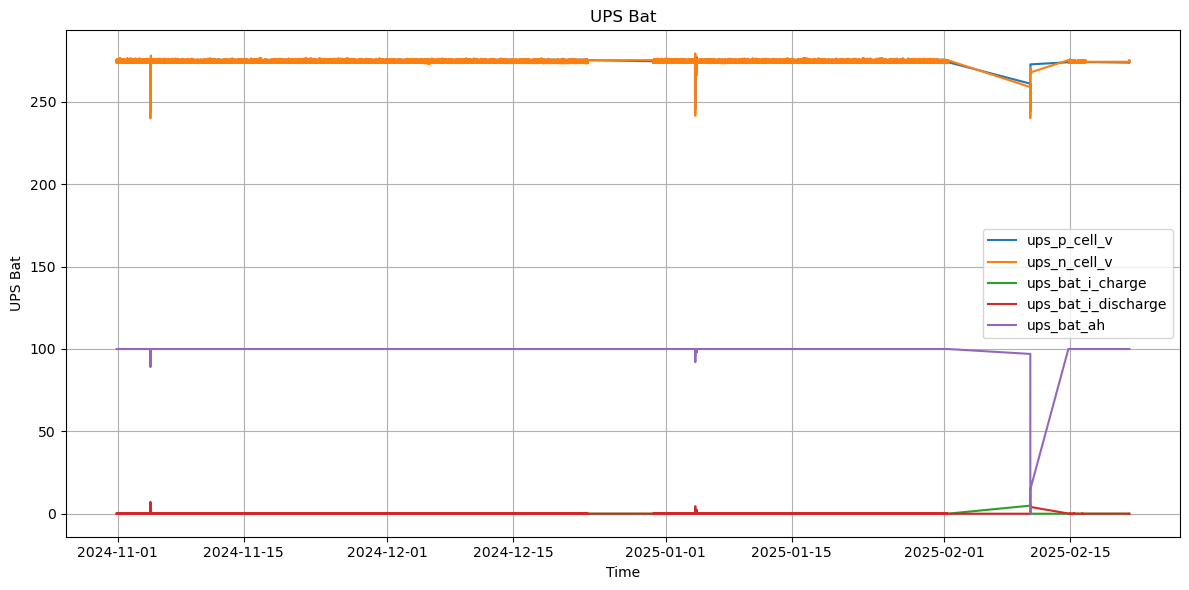

Epoch 1/50


C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ghofr\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5491 - val_loss: 0.3837
Epoch 2/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5423 - val_loss: 0.3665
Epoch 3/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4799 - val_loss: 0.3543
Epoch 4/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4456 - val_loss: 0.3482
Epoch 5/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4188 - val_loss: 0.3412
Epoch 6/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3860 - val_loss: 0.3425
Epoch 7/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3972 - val_loss: 0.3382
Epoch 8/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3963 - val_loss: 0.3365
Epoch 9/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3851 - val_loss: 0.3310
Epoch 10/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3980 - val_loss: 0.3290
Epoch 11/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3777 - val_loss: 0.3282
Epoch 12/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.

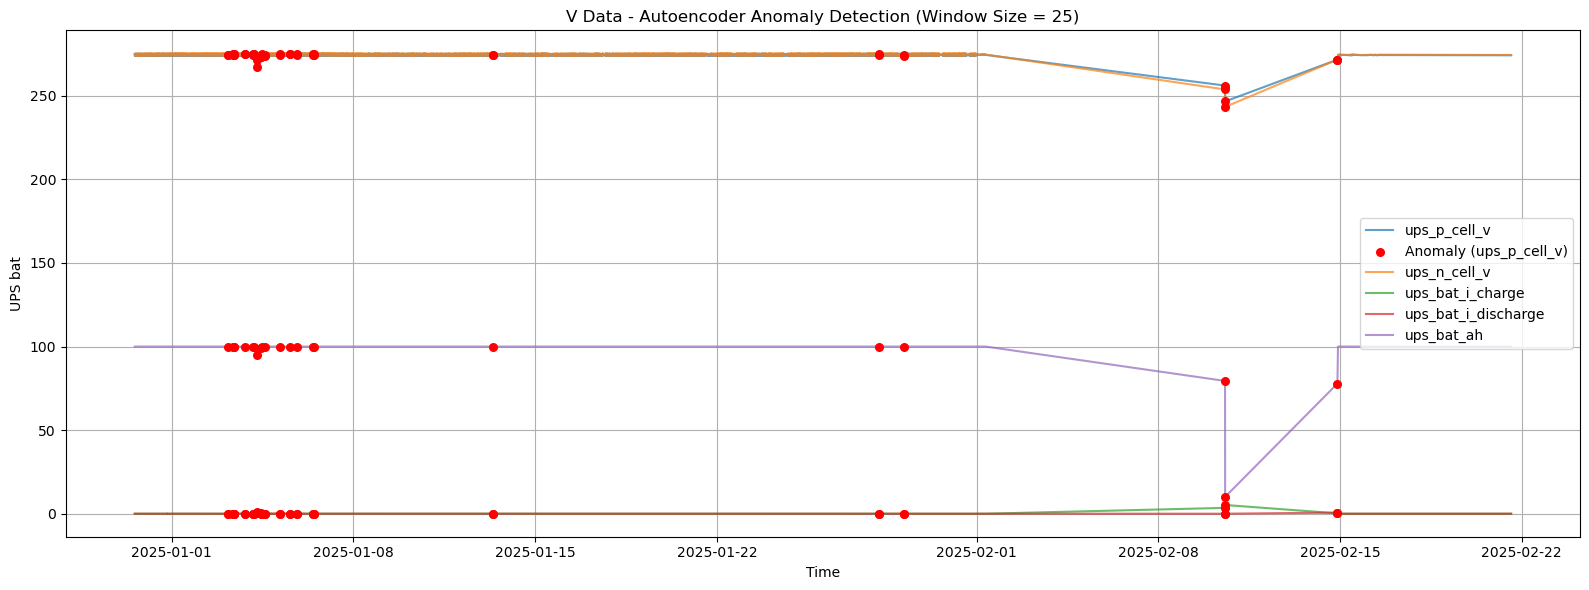

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
# Supervisor anomaly intervals
supervisor_anomalies = [
    (pd.Timestamp('2025-01-04 06:40'), pd.Timestamp('2025-01-04 06:42')),
    (pd.Timestamp('2025-01-04 06:42'), pd.Timestamp('2025-01-04 06:44')),
    (pd.Timestamp('2025-02-10 13:39'), pd.Timestamp('2025-02-10 13:41')),
    (pd.Timestamp('2025-02-10 13:41'), pd.Timestamp('2025-02-10 13:59')),
    (pd.Timestamp('2025-02-14 19:21'), pd.Timestamp('2025-02-14 19:23'))
]

# Evaluation helpers
def is_true_positive(ts, intervals):
    return any(start <= ts <= end for start, end in intervals)

def compare_anomalies(detected_indices, intervals):
    true_positives = [ts for ts in detected_indices if is_true_positive(ts, intervals)]
    false_positives = [ts for ts in detected_indices if not is_true_positive(ts, intervals)]
    false_negatives = [interval for interval in intervals if not any(is_true_positive(ts, [interval]) for ts in detected_indices)]
    return true_positives, false_positives, false_negatives

def window_dataframe_bat(df, window_size=12):
    """
    Transform UPS DataFrame into windowed format.
    Returns a DataFrame where each row is a time window of fixed size,
    and columns are named by variable and time index.
    """
    n_rows = df.shape[0]
    n_windows = n_rows // window_size
    df_trunc = df.iloc[:n_windows * window_size]
    data = df_trunc.values.reshape(n_windows, window_size, df.shape[1])

    # Build new column names: for each variable, all window steps
    new_columns = []
    for col in df.columns:
        for i in range(window_size):
            new_columns.append(f"{col}-{i+1}")
    # Transpose axes to get all time steps for each variable together
    data_2d = data.transpose(0, 2, 1).reshape(n_windows, -1)
    return pd.DataFrame(data_2d, columns=new_columns)


# Plot raw voltage means
bat_phases = ['ups_p_cell_v', 'ups_n_cell_v', 'ups_bat_i_charge', 'ups_bat_i_discharge', 'ups_bat_ah']
df_ups['data_hora'] = pd.to_datetime(df_ups['data_hora'])
df_ups = df_ups.sort_values('data_hora')
plt.figure(figsize=(12, 6))
for phase in bat_phases:
    plt.plot(df_ups['data_hora'], df_ups[phase], label=phase)
plt.title("UPS Bat")
plt.xlabel("Time")
plt.ylabel("UPS Bat")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Best model and window selection (from previous summary)
best_window_volt = 25
best_model_volt = "Autoencoder"

# Prepare data
df_bat_ups = df_ups[['ups_p_cell_v', 'ups_n_cell_v', 'ups_bat_i_charge', 'ups_bat_i_discharge', 'ups_bat_ah']].copy()
df_bat_ups_win = window_dataframe_bat(df_bat_ups, window_size=best_window_volt)
df_bat_ups_win_plot = df_bat_ups_win.copy()
bat_phases_clean = ['ups_p_cell_v', 'ups_n_cell_v', 'ups_bat_i_charge', 'ups_bat_i_discharge', 'ups_bat_ah']
for phase in bat_phases_clean:
    cols = [f"{phase}-{i+1}" for i in range(best_window_volt)]
    missing_cols = [col for col in cols if col not in df_bat_ups_win_plot.columns]
    if missing_cols:
        print(f"Colonnes manquantes pour {phase} : {missing_cols}")
        continue
    df_bat_ups_win_plot[f"{phase}_mean"] = df_bat_ups_win_plot[cols].mean(axis=1)
timestamps_bat = df_ups['data_hora'].sort_values().values
n_windows_bat = len(df_bat_ups_win_plot)
window_timestamps_bat = [timestamps_bat[(i+1)*best_window_volt - 1] for i in range(n_windows_bat)]
df_bat_ups_win_plot['window_time'] = pd.to_datetime(window_timestamps_bat)
df_bat_ups_win_plot = df_bat_ups_win_plot.set_index('window_time')

# Train-test split
test_start_bat = pd.to_datetime('2024-12-29')
test_end_bat = pd.to_datetime('2025-02-23')
test_mask_bat = (df_bat_ups_win_plot.index >= test_start_bat) & (df_bat_ups_win_plot.index <= test_end_bat)
df_test_bat = df_bat_ups_win_plot[test_mask_bat].copy()
df_train_bat = df_bat_ups_win_plot[~test_mask_bat].copy()

X_train_bat = df_train_bat.drop(columns=[c for c in df_train_bat.columns if c.endswith('_mean')])
X_test_bat = df_test_bat.drop(columns=[c for c in df_test_bat.columns if c.endswith('_mean')])

# === Final Autoencoder ===
def build_final_autoencoder_volt(input_dim):
    model = Sequential()
    model.add(Dense(64, input_shape=(input_dim,), kernel_regularizer=regularizers.l2(1e-4)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.1))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-4)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(16, kernel_regularizer=regularizers.l2(1e-4)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(input_dim, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

# === Final LSTM ===
def build_final_lstm_volt(seq_len, n_features):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(seq_len, n_features)),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        RepeatVector(seq_len),
        LSTM(32, return_sequences=True),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        LeakyReLU(alpha=0.1),
        TimeDistributed(Dense(n_features))
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return model

if best_model_volt == "Autoencoder":
    scaler_volt = StandardScaler()
    X_train_volt_scaled = scaler_volt.fit_transform(X_train_v)
    X_test_volt_scaled = scaler_volt.transform(X_test_v)
    model_volt = build_final_autoencoder_volt(X_train_volt_scaled.shape[1])
    model_volt.fit(X_train_volt_scaled, X_train_volt_scaled, epochs=50, batch_size=32, validation_split=0.1,
              callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=1)
    recon_volt = model_volt.predict(X_test_volt_scaled)
    errors_volt = np.mean(np.square(X_test_volt_scaled - recon_volt), axis=1)
else:
    scaler_volt = MinMaxScaler()
    X_train_volt_scaled = scaler_volt.fit_transform(X_train_v)
    X_test_volt_scaled = scaler_volt.transform(X_test_v)
    n_features_volt = 5
    sequence_length_volt = best_window_volt
    X_train_seq_volt = X_train_volt_scaled.reshape(-1, sequence_length_volt, n_features_volt)
    X_test_seq_volt = X_test_volt_scaled.reshape(-1, sequence_length_volt, n_features_volt)
    model_volt = build_final_lstm_volt(sequence_length_volt, n_features_volt)
    model_volt.fit(X_train_seq_volt, X_train_seq_volt, epochs=50, batch_size=32, validation_split=0.1,
              callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=1)
    recon_seq_volt = model_volt.predict(X_test_seq_volt)
    errors_volt = np.mean(np.square(X_test_seq_volt - recon_seq_volt), axis=(1, 2))

threshold_volt = np.percentile(errors_volt, 99.8)
anomalies_volt = errors_volt > threshold_volt
df_test_bat['anomaly_score'] = errors_volt
df_test_bat['predicted_label'] = anomalies_volt.astype(int)

# Plot final anomaly results
phase_labels_bat = ['ups_p_cell_v', 'ups_n_cell_v', 'ups_bat_i_charge', 'ups_bat_i_discharge', 'ups_bat_ah']
plt.figure(figsize=(16, 6))
for phase, label in zip(bat_phases_clean, phase_labels_bat):
    plt.plot(df_test_bat.index, df_test_bat[f"{phase}_mean"], label=label, alpha=0.7)
    plt.scatter(
        df_test_bat.index[df_test_bat['predicted_label'] == 1],
        df_test_bat.loc[df_test_bat['predicted_label'] == 1, f"{phase}_mean"],
        color='red', s=30, zorder=10, label=f"Anomaly ({label})" if phase == bat_phases_clean[0] else ""
    )
plt.title(f"V Data - {best_model_volt} Anomaly Detection (Window Size = {best_window_volt})")
plt.xlabel("Time")
plt.ylabel("UPS bat")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [117]:
# Compare to supervisor labels for voltage data
detected_v_anomalies = df_test_v.index[df_test_v['predicted_label'] == 1]
tp_volt, fp_volt, fn_volt = compare_anomalies(detected_v_anomalies, supervisor_anomalies)

# Create and display summary
bat_summary = pd.DataFrame({
    "Model": [best_model_volt],
    "Window Size": [best_window_volt],
    "Total Detected": [len(detected_v_anomalies)],
    "True Positives": [len(tp_volt)],
    "False Positives": [len(fp_volt)],
    "False Negatives": [len(fn_volt)],
})

print("\nBat Anomaly Detection Performance Summary:")
bat_summary


Bat Anomaly Detection Performance Summary:


,Model,Window Size,Total Detected,True Positives,False Positives,False Negatives
0,Autoencoder,25,22,3,19,3


In [118]:
# Print detailed results
print("\nDetailed Results:")
print(f"Total anomalies detected: {len(detected_v_anomalies)}")
print(f"True positives: {len(tp_volt)}")
print(f"False positives: {len(fp_volt)}")
print(f"False negatives: {len(fn_volt)}")

# Print the actual timestamps of anomalies
print("\nDetected Bat Anomaly Timestamps:")
print(detected_v_anomalies)

# Print supervisor's anomaly intervals that were missed (false negatives)
if len(fn_volt) > 0:
    print("\nMissed Bat Anomaly Intervals (False Negatives):")
    for interval in fn_volt:
        print(f"From {interval[0]} to {interval[1]}")
else:
    print("\nNo missed Bat anomalies (all supervisor intervals detected)")


Detailed Results:
Total anomalies detected: 22
True positives: 3
False positives: 19
False negatives: 3

Detected Bat Anomaly Timestamps:
DatetimeIndex(['2025-01-02 22:31:59', '2025-01-03 03:50:35',
               '2025-01-03 08:55:56', '2025-01-03 09:08:48',
               '2025-01-03 19:28:09', '2025-01-03 21:54:27',
               '2025-01-04 03:25:14', '2025-01-04 06:42:56',
               '2025-01-04 10:35:13', '2025-01-05 00:20:57',
               '2025-01-05 04:04:24', '2025-01-05 10:52:39',
               '2025-01-05 19:34:12', '2025-01-06 10:37:43',
               '2025-01-06 11:37:45', '2025-01-13 09:10:14',
               '2025-01-26 23:58:00', '2025-01-27 23:41:59',
               '2025-01-29 05:04:32', '2025-02-10 13:41:55',
               '2025-02-10 13:46:13', '2025-02-14 21:35:34'],
              dtype='datetime64[ns]', name='window_time', freq=None)

Missed Bat Anomaly Intervals (False Negatives):
From 2025-01-04 06:40:00 to 2025-01-04 06:42:00
From 2025-02-10 13:39:0

### Saving Model

In [119]:
from joblib import dump
from tensorflow.keras.models import save_model
import os

# === Step 1: Définir un dossier local (ex: projet dans ton home dir ou un dossier spécifique) ===
base_dir = "anomaly_detection_project"  # ou un chemin complet, ex: "C:/Users/TonNom/Documents/anomaly_detection_project"

# Sous-dossiers par type de mesure
subset_dirs = {
    "UPS_V": os.path.join(base_dir, "UPS_V"),
    "UPS_P": os.path.join(base_dir, "UPS_P"),
    "UPS_I": os.path.join(base_dir, "UPS_I"),
    "UPS_bat": os.path.join(base_dir, "UPS_bat")
}

# Créer les dossiers si besoin
for dir_path in subset_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# === Step 2: Sauvegarder le modèle et le scaler ===
save_model(model_volt, os.path.join(subset_dirs["UPS_bat"], "autoencoder_model.keras"))
dump(scaler_volt, os.path.join(subset_dirs["UPS_bat"], "scaler.pkl"))

# === Step 3: Sauvegarder les résultats (si `voltage_summary` existe) ===
bat_summary.to_csv(os.path.join(subset_dirs["UPS_bat"], "summary.csv"), index=False)

In [120]:
import os
from tensorflow.keras.models import load_model
from joblib import load

# === Base path local ===
base_dir = "anomaly_detection_project"  # ou un chemin absolu comme "C:/Users/TonNom/Documents/anomaly_detection_project"

# === Nom du sous-dossier (doit correspondre à la sauvegarde précédente) ===
subset = "UPS_bat"  # <- par exemple, pour voltage

# === Construction des chemins ===
model_path = os.path.join(base_dir, subset, "autoencoder_model.keras")
scaler_path = os.path.join(base_dir, subset, "scaler.pkl")

# === Chargement ===
model = load_model(model_path)
scaler = load(scaler_path)

print("✅ Model and scaler loaded successfully!")

✅ Model and scaler loaded successfully!
